## Содержание:
* [Получение данных о трафике из API Яндекс Метрики](#1)
* [-- Библиотеки](#2)
* [-- Общие функции](#3)
<br>
<br>
* [Часть 1: Получение количества визитов ](#4)
* [-- Первый запрос для демонстрации получаемых данных](#5)
* [-- Получение количества визитов за период из всех поисковых систем](#6)
* [-- Получение количества визитов за период из какой-либо поисковой системы](#7)
* [-- Визуализация](#8)
<br>
<br>
* [Часть 2: Получение визитов по страницам входа, анализ распределения ](#9)
* [-- Распределение за период](#10)
* [-- Распределение по месяцам](#11)
<br>
<br>
* [Часть 3: Получение визитов по страницам входа, анализ динамики трафика по каждому URL](#12)


# Получение данных о трафике из API Яндекс Метрики<a class="anchor" id="1"></a>

# Библиотеки<a class="anchor" id="2"></a>

In [1]:
import requests
import json

import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [2]:
YANDEX_TOKEN = 'y0_AgAAAAASqca9YYaElQFFFFDf0c6gbPilbUJpQl-OVox2FC5UvOMecnNO'

In [3]:
METRIKA_URL_TEMPLATE = 'https://api-metrika.yandex.net/stat/v1/data'

# Общие функции<a class="anchor" id="3"></a>

Эти функции будут использоваться в скриптах ниже.

## Авторизация

In [4]:
def get_auth_headers():
    return {'Authorization': f'OAuth {YANDEX_TOKEN}'}

## Открывание таблицы с отчетом 

Функция открывает csv с названием, которое указано в REPORT_TABLE_NAME. Если такой таблицы нет, создается таблица с нужными полями и открывается:

In [5]:
def open_csv():
    try:
        table = pd.read_csv(REPORT_TABLE_NAME)
        
        return table.to_dict('records')
    
    except:
        report_table = {}
        report_table['data_type'] = np.nan
        report_table['value'] = np.nan
        report_table['date'] = np.nan
        report_table['week_number_year'] = np.nan
        report_table['month_year'] = np.nan
        
        table_template = pd.DataFrame(report_table, index=[0])
        table_template.to_csv(REPORT_TABLE_NAME, index=False)
        table = pd.read_csv(REPORT_TABLE_NAME)
        
        return table.to_dict('records')

## Создание отчета

Принимает открытую функцией open_csv таблицу, тип значение - например все поисковые системы, переходы из яндекса и т.д., количество переходом, дату, день, номер недели, название месяца, год. Все записывается в датафрейм pandas, потом экспортируется:

In [6]:
def create_report(report_table, data_type, value, date, week_number_year, month_year):
    d={}
    d['data_type'] = data_type
    d['value'] = value
    d['date'] = date
    d['week_number_year'] = week_number_year
    d['month_year'] = month_year
    
    report_table.append(d)
    
    result_table = pd.DataFrame.from_dict(report_table)
    
    result_table.dropna(inplace=True)
    
    result_table['value'] = result_table['value'].astype(int)
    
    result_table.to_csv(REPORT_TABLE_NAME, index=False)

Дополнительно все поля, содержащие числовые значения приводятся к формату целых чисел.

# Часть 1: Получение количества визитов <a class="anchor" id="4"></a>

Id счетчика метрики:

In [7]:
PROJECT_COUNTER_ID = 44771542

Название таблицы для записи полученных данных:

In [8]:
REPORT_TABLE_NAME = 'report_table.csv'

# Первый запрос для демонстрации получаемых данных <a class="anchor" id="5"></a>

Дата:

In [9]:
date = '2020-12-31'

Группировка (dimensions) - поисковые системы, метрика (metrics) - визиты, атрибуция - последний значимый переход кросс девайс:

In [10]:
DIMENSIONS = 'ym:s:searchEngine'
METRICS = 'ym:s:visits'
ATTRIBUTION = 'cross_device_last_significant'

## Функция для отправки параметров

Принимает дату и счетчик метрики:

In [11]:
def metrika_get_params(current_date, project_yandex_metrika_counter_id):
    return {
                    'id': project_yandex_metrika_counter_id,
                    'date1': current_date,
                    'date2': current_date,
                    'dimensions': DIMENSIONS,
                    'attribution': ATTRIBUTION,
                    'sampled': False,
                    'metrics': METRICS,
                }

## Запрос

In [12]:
request = requests.get(METRIKA_URL_TEMPLATE,
                       headers=get_auth_headers(),
                       params=metrika_get_params(date, PROJECT_COUNTER_ID))

In [13]:
json.loads(request.text)

{'query': {'ids': [44771542],
  'dimensions': ['ym:s:searchEngine'],
  'metrics': ['ym:s:visits'],
  'sort': ['-ym:s:visits'],
  'date1': '2020-12-31',
  'date2': '2020-12-31',
  'limit': 100,
  'offset': 1,
  'attribution': 'cross_device_last_significant',
  'group': 'Week',
  'auto_group_size': '1',
  'attr_name': '',
  'quantile': '50',
  'offline_window': '21',
  'currency': 'RUB',
  'adfox_event_id': '0'},
 'data': [{'dimensions': [{'name': 'Yandex, search results',
     'id': 'yandex_search',
     'favicon': 'www.yandex.ru'}],
   'metrics': [358.0]},
  {'dimensions': [{'name': 'Yandex Mobile',
     'id': 'yandex_mobile',
     'favicon': 'm.yandex.ru'}],
   'metrics': [262.0]},
  {'dimensions': [{'name': 'Yandex: mobile app',
     'id': 'yandex_mobile_app',
     'favicon': 'www.yandex.ru'}],
   'metrics': [147.0]},
  {'dimensions': [{'name': 'Google, search results',
     'id': 'google_search',
     'favicon': 'google.com'}],
   'metrics': [11.0]},
  {'dimensions': [{'name': 'Yand

Результат за 1 день - 31 декабря 2020 года. Ключ data содержит информацию о том, из каких поисковых систем сколько раз совершались переходы. Обратите внимание, что переходы из поиска Яндекса, переходы из мобильного поиска Яндекса, переходы из мобильного приложения поиска Яндекса, переходы из картинок Яндекса, переходы с карт Яндекса определяются как отдельные источники. Общее количество переходов отражено в ключе total - 1339.

# Получение количества визитов за период из всех поисковых систем<a class="anchor" id="6"></a>

Даты:

In [14]:
date_from = '2019-01-01'

In [15]:
date_to = '2020-12-31'

Такие же параметры, как в примере выше. Группировка (dimensions) - поисковые системы, метрика (metrics) - визиты, атрибуция - последний значимый переход кросс девайс:

In [16]:
DIMENSIONS = 'ym:s:searchEngine'
METRICS = 'ym:s:visits'
ATTRIBUTION = 'cross_device_last_significant'

## Функция для отправки параметров

Принимает дату и счетчик метрики:

In [17]:
def metrika_get_params(current_date, project_yandex_metrika_counter_id):
    return {
                    'id': project_yandex_metrika_counter_id,
                    'date1': current_date,
                    'date2': current_date,
                    'dimensions': DIMENSIONS,
                    'attribution': ATTRIBUTION,
                    'sampled': False,
                    'metrics': METRICS,
                }

## Функция для получения данных из метрики и формирования отчета

Принимает дату, номер счетсчика. Для отчета полная дата конвертируется в строку, из даты определяется день, номер недели в году, название месяца и год, и все записывается в разные поля:

In [24]:
def get_all_search_engine_data_and_report(current_date, project_yandex_metrika_counter_id):
    request = requests.get(METRIKA_URL_TEMPLATE,
                           headers=get_auth_headers(),
                           params=metrika_get_params(current_date, project_yandex_metrika_counter_id))
    
    request_data = json.loads(request.text)
        
    se_visits_quantity = request_data['totals'][0]
    
    date = current_date.strftime('%d-%m-%Y')
    week_number_year = current_date.strftime('%W %Y')
    month_year = current_date.strftime('%B %Y')

    report_table = open_csv()
    
    create_report(report_table, 'se_all', se_visits_quantity, date, week_number_year, month_year)

## Запуск

In [25]:
for day in pd.period_range(start=date_from,end=date_to, freq='D'):
    get_all_search_engine_data_and_report(day, PROJECT_COUNTER_ID)

### Просмотр созданного отчета в csv

In [26]:
pd.read_csv(REPORT_TABLE_NAME)

,data_type,value,date,week_number_year,month_year
0,se_all,40,01-01-2019,00 2019,January 2019
1,se_all,68,02-01-2019,00 2019,January 2019
2,se_all,117,03-01-2019,00 2019,January 2019
3,se_all,105,04-01-2019,00 2019,January 2019
4,se_all,70,05-01-2019,00 2019,January 2019
...,...,...,...,...,...
726,se_all,1813,27-12-2020,51 2020,December 2020
727,se_all,1809,28-12-2020,52 2020,December 2020
728,se_all,1634,29-12-2020,52 2020,December 2020
729,se_all,1412,30-12-2020,52 2020,December 2020


# Получение количества визитов за период из какой-либо поисковой системы<a class="anchor" id="7"></a>

Даты:

In [34]:
date_from = '2019-01-01'

In [35]:
date_to = '2020-12-31'

Такие же параметры, как в примере выше. Группировка (dimensions) - поисковые системы, метрика (metrics) - визиты, атрибуция - последний значимый переход кросс девайс, фильтрация (filters) по названию поисковой системы:

In [36]:
DIMENSIONS = 'ym:s:searchEngine'
ATTRIBUTION = 'cross_device_last_significant'
METRICS = 'ym:s:visits'
FILTERS = "ym:s:SearchEngineName=*'{}*'"

## Функция для отправки параметров

Принимает дату, название поисковика и счетчик метрики:

In [37]:
def metrika_get_params(current_date, search_engine_name, project_yandex_metrika_counter_id):
    return {
                    'id': project_yandex_metrika_counter_id,
                    'date1': current_date,
                    'date2': current_date,
                    'dimensions': DIMENSIONS,
                    'attribution': ATTRIBUTION,
                    'sampled': False,
                    'metrics': METRICS,
                    'filters': FILTERS.format(search_engine_name)
                }

## Функция для получения данных из метрики  по названию ПС и формирования отчета

Принимает дату, название поисковика, номер счетчика. Для отчета полная дата конвертируется в строку, из даты определяется день, номер недели в году, название месяца и год, и все записывается в разные поля:

In [38]:
def get_current_search_engine_data_and_report(current_date, search_engine_name, 
                                              project_yandex_metrika_counter_id):
    
    request = requests.get(METRIKA_URL_TEMPLATE,
                           headers=get_auth_headers(),
                           params=metrika_get_params(current_date, search_engine_name, 
                                                     project_yandex_metrika_counter_id))
                
    request_data = json.loads(request.text)
    
    se_visits_quantity = request_data['totals'][0]
    
    date = current_date.strftime('%Y-%m-%d')
    week_number_year = current_date.strftime('%W %Y')
    month_year = current_date.strftime('%B %Y')

    report_table = open_csv()
    
    create_report(report_table, search_engine_name, se_visits_quantity, date, week_number_year, month_year)

## Запуск

### Получение количества визитов из Яндекса

In [41]:
for day in pd.period_range(start=date_from,end=date_to, freq='D'):
    get_current_search_engine_data_and_report(day, 'yandex', PROJECT_COUNTER_ID)

####  Просмотр таблицы

In [42]:
pd.read_csv(REPORT_TABLE_NAME)

,data_type,value,date,week_number_year,month_year
0,se_all,40,01-01-2019,00 2019,January 2019
1,se_all,68,02-01-2019,00 2019,January 2019
2,se_all,117,03-01-2019,00 2019,January 2019
3,se_all,105,04-01-2019,00 2019,January 2019
4,se_all,70,05-01-2019,00 2019,January 2019
...,...,...,...,...,...
1457,yandex,1768,2020-12-27,51 2020,December 2020
1458,yandex,1776,2020-12-28,52 2020,December 2020
1459,yandex,1597,2020-12-29,52 2020,December 2020
1460,yandex,1388,2020-12-30,52 2020,December 2020


### Получение количества визитов из Google

In [43]:
for day in pd.period_range(start=date_from,end=date_to, freq='D'):
    get_current_search_engine_data_and_report(day, 'google', PROJECT_COUNTER_ID)

####  Просмотр таблицы

In [44]:
pd.read_csv(REPORT_TABLE_NAME)

,data_type,value,date,week_number_year,month_year
0,se_all,40,01-01-2019,00 2019,January 2019
1,se_all,68,02-01-2019,00 2019,January 2019
2,se_all,117,03-01-2019,00 2019,January 2019
3,se_all,105,04-01-2019,00 2019,January 2019
4,se_all,70,05-01-2019,00 2019,January 2019
...,...,...,...,...,...
2188,google,39,2020-12-27,51 2020,December 2020
2189,google,28,2020-12-28,52 2020,December 2020
2190,google,32,2020-12-29,52 2020,December 2020
2191,google,21,2020-12-30,52 2020,December 2020


# Визуализация<a class="anchor" id="8"></a>

## Загрузка таблицы

In [45]:
df = pd.read_csv(REPORT_TABLE_NAME)

In [46]:
df.head()

,data_type,value,date,week_number_year,month_year
0,se_all,40,01-01-2019,00 2019,January 2019
1,se_all,68,02-01-2019,00 2019,January 2019
2,se_all,117,03-01-2019,00 2019,January 2019
3,se_all,105,04-01-2019,00 2019,January 2019
4,se_all,70,05-01-2019,00 2019,January 2019


## Срез по всем поисковым системам

In [47]:
se_all_slice = df[df['data_type'] == 'se_all']

## Линейный график

В срезе по всем поисковым системам находятся данные по трафику за каждый день за период 2019-2020 гг. Если построить график с детализацией по дням, получится нечитаемая картина:

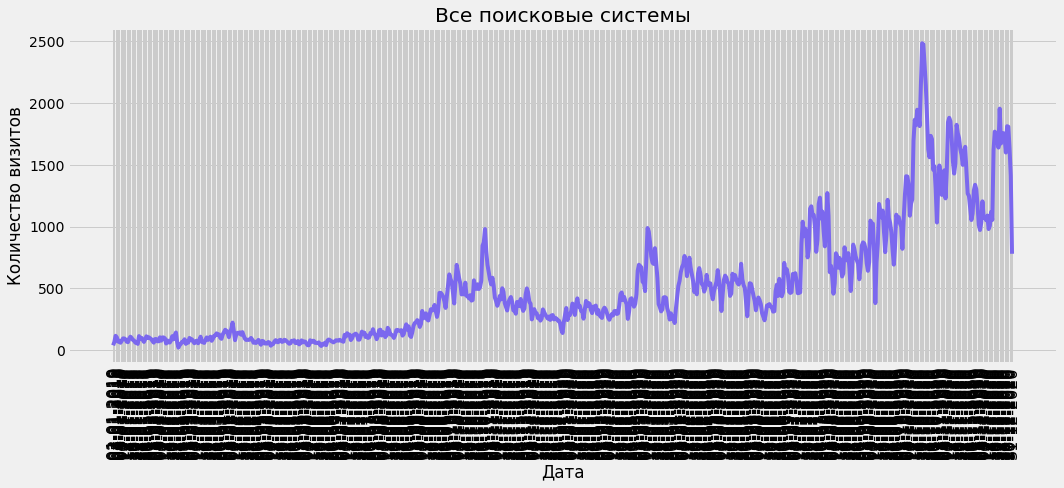

In [48]:
with plt.style.context('fivethirtyeight'):

    plt.figure(figsize=(15,7))
    
    dates_x = se_all_slice['date']
    values_y = se_all_slice['value']
    
    plt.plot(dates_x, values_y, color='mediumslateblue')
    
    plt.xticks(rotation=90, fontsize=16)
    plt.title('Все поисковые системы')
    plt.ylabel('Количество визитов')
    plt.xlabel('Дата')
    plt.tight_layout()
    plt.savefig(f'traffic-from-all-search-engines.png')

### Группировка по месяцам

Для этого на этапе получения данных из Метрики было подготовлено поле month_year. Теперь можно сгруппировать данные по трафику по месяцам:

In [49]:
by_month = se_all_slice.pivot_table(index='month_year', values='value', 
                                    aggfunc='sum', sort=False).reset_index()

In [50]:
by_month.head()

,month_year,value
0,January 2019,2644
1,February 2019,2262
2,March 2019,2781
3,April 2019,3475
4,May 2019,2052


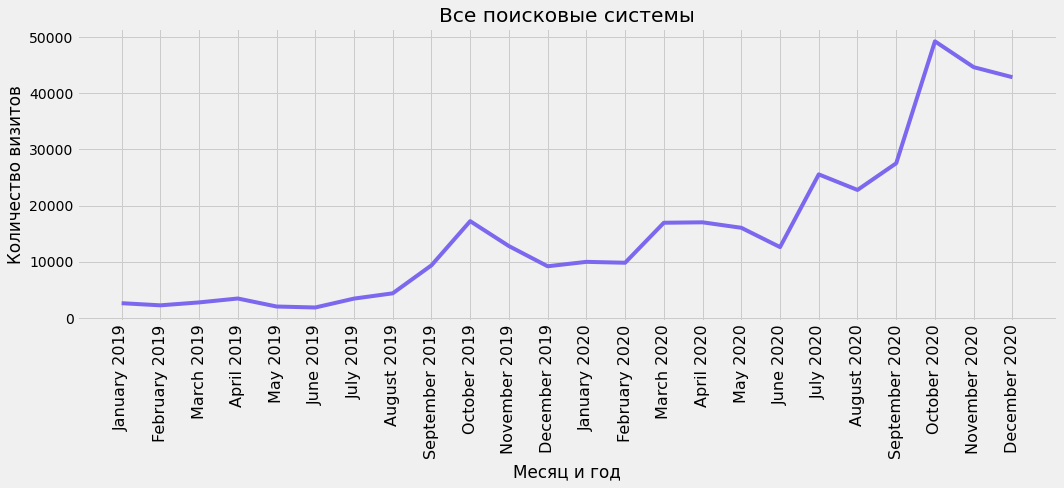

In [51]:
with plt.style.context('fivethirtyeight'):

    plt.figure(figsize=(15,7))
    
    dates_x = by_month['month_year']
    values_y = by_month['value']
    
    plt.plot(dates_x, values_y, color='mediumslateblue')
    
    plt.xticks(rotation=90, fontsize=16)
    plt.title('Все поисковые системы')
    plt.ylabel('Количество визитов')
    plt.xlabel('Месяц и год')
    plt.tight_layout()
    plt.savefig(f'traffic-from-all-search-engines-by-months.png')

### Группировка по неделям

Также на этапе получения данных было подготовлено поле с номером недели в году week_number_year:

In [52]:
by_week = se_all_slice.pivot_table(index='week_number_year', values='value', 
                                   aggfunc='sum', sort=False).reset_index()

Если запустить график без дополнительных настроек, на оси X номера недель слипнутся. На 9 и 10 строке написаны настройки, с помощью которых количество подписей на оси X будет сокращено автоматически. Попробуйте менять параметры в AutoDateLocator - minticks и maxticks:

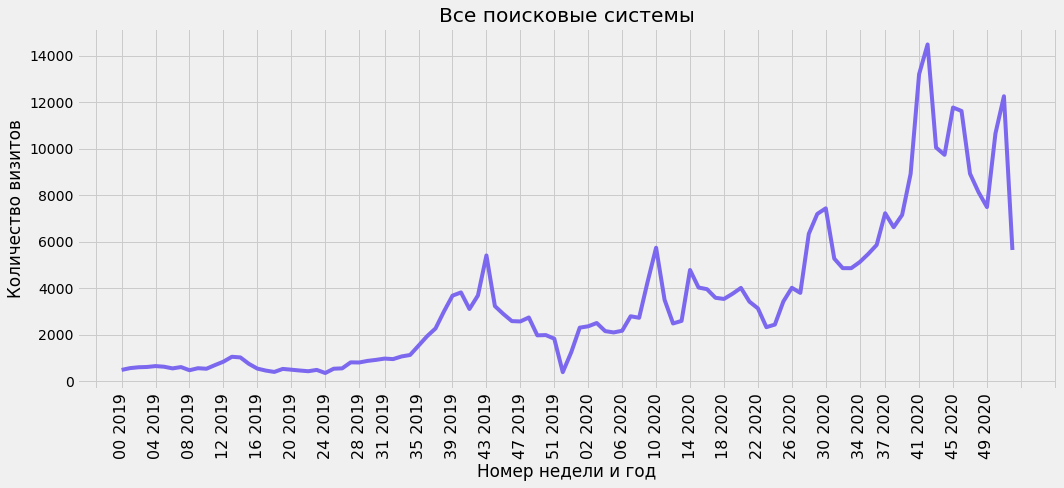

In [53]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(15,7))
    
    dates_x = by_week['week_number_year']
    values_y = by_week['value']
    
    plt.plot(dates_x, values_y, color='mediumslateblue')
    
    plt.rcParams['date.converter'] = 'concise'
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=58))
    
    plt.xticks(rotation=90, fontsize=16)
    plt.title('Все поисковые системы')
    plt.ylabel('Количество визитов')
    plt.xlabel('Номер недели и год')
    plt.tight_layout()
    plt.savefig(f'traffic-from-all-search-engines-by-weeks.png')

### Вывод данных по дням

В первом примере на графике был выбран двухлетний период, и данные по дням выглядели нечитаемо. Чтобы лучше визуализироть данные по дням, нужно взять более короткий период.

Можно сделать срез за какой-либо определенный месяц, например за декабрь 2020:

In [54]:
selected_month = se_all_slice[se_all_slice['month_year'] == 'December 2020']

In [55]:
selected_month.head()

,data_type,value,date,week_number_year,month_year
700,se_all,1339,01-12-2020,48 2020,December 2020
701,se_all,1302,02-12-2020,48 2020,December 2020
702,se_all,1172,03-12-2020,48 2020,December 2020
703,se_all,1016,04-12-2020,48 2020,December 2020
704,se_all,973,05-12-2020,48 2020,December 2020


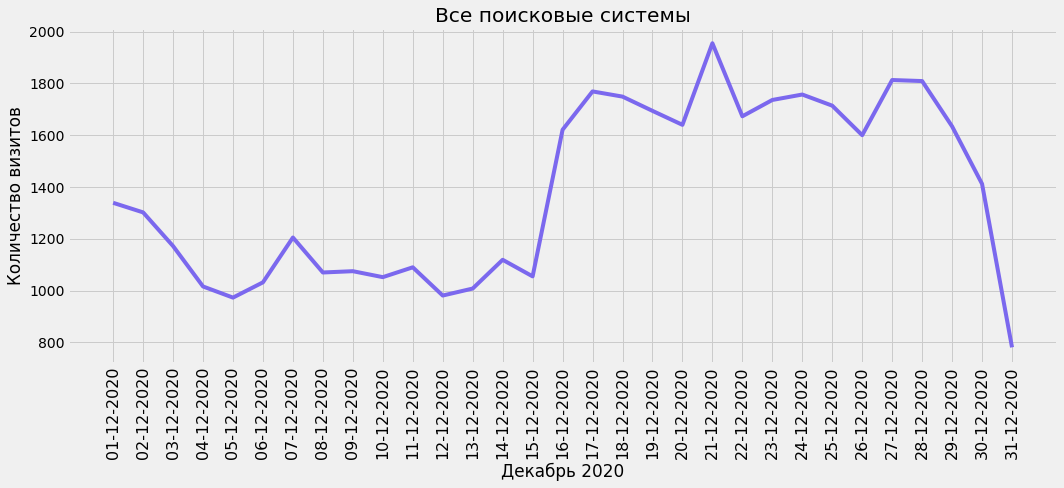

In [56]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(15,7))
    
    dates_x = selected_month['date']
    values_y = selected_month['value']
    
    plt.plot(dates_x, values_y, color='mediumslateblue')
    
    plt.xticks(rotation=90, fontsize=16)
    plt.title('Все поисковые системы')
    plt.ylabel('Количество визитов')
    plt.xlabel('Декабрь 2020')
    plt.tight_layout()
    plt.savefig(f'traffic-from-all-search-engines-december-2020.png')

Можно сделать срез из произвольного периода, для этого нужно знать индекс первой и последней строки в срезе, например срез с первого января до середины февраля 2019 года:

In [57]:
selected_period = se_all_slice.iloc[0:45]

In [58]:
selected_period

,data_type,value,date,week_number_year,month_year
0,se_all,40,01-01-2019,00 2019,January 2019
1,se_all,68,02-01-2019,00 2019,January 2019
2,se_all,117,03-01-2019,00 2019,January 2019
3,se_all,105,04-01-2019,00 2019,January 2019
4,se_all,70,05-01-2019,00 2019,January 2019
5,se_all,77,06-01-2019,00 2019,January 2019
6,se_all,61,07-01-2019,01 2019,January 2019
7,se_all,77,08-01-2019,01 2019,January 2019
8,se_all,96,09-01-2019,01 2019,January 2019
9,se_all,96,10-01-2019,01 2019,January 2019


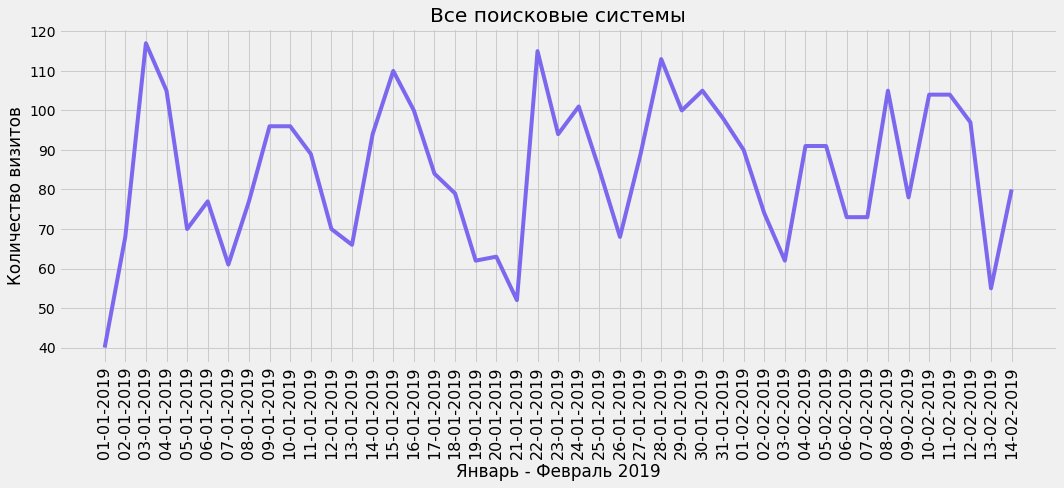

In [59]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(15,7))
    
    dates_x = selected_period['date']
    values_y = selected_period['value']
    
    plt.plot(dates_x, values_y, color='mediumslateblue')
    
    plt.xticks(rotation=90, fontsize=16)
    plt.title('Все поисковые системы')
    plt.ylabel('Количество визитов')
    plt.xlabel('Январь - Февраль 2019')
    plt.tight_layout()
    plt.savefig(f'traffic-from-all-search-engines-period.png')

Вместо данных о трафике из всех поисковых систем, можно детализироваться по конкретной. Например, визуализация трафика из Яндекса, сгруппированного по месяцам:

In [60]:
yandex_slice = df[df['data_type'] == 'yandex']

In [61]:
yandex_by_month = yandex_slice.pivot_table(index='month_year', values='value', 
                                    aggfunc='sum', sort=False).reset_index()

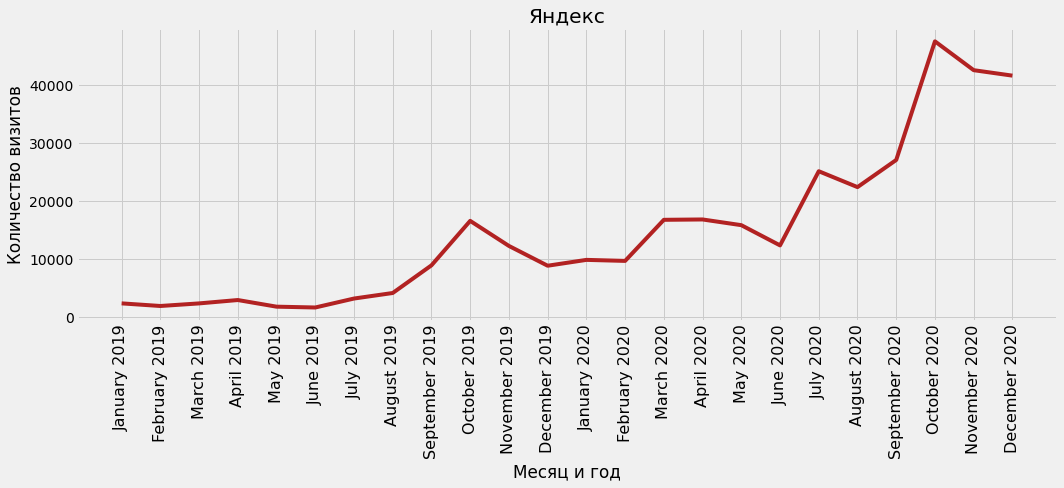

In [63]:
with plt.style.context('fivethirtyeight'):

    plt.figure(figsize=(15,7))
    
    dates_x = yandex_by_month['month_year']
    values_y = yandex_by_month['value']
    
    plt.plot(dates_x, values_y, color='firebrick')
    
    plt.xticks(rotation=90, fontsize=16)
    plt.title('Яндекс')
    plt.ylabel('Количество визитов')
    plt.xlabel('Месяц и год')
    plt.tight_layout()
    plt.savefig(f'traffic-from-yandex.png')

## Столчатый график

Вместо линейного графика можно использовать столбчатый. Например, трафик из всех поисковых систем, сгурппированный по месяцам:

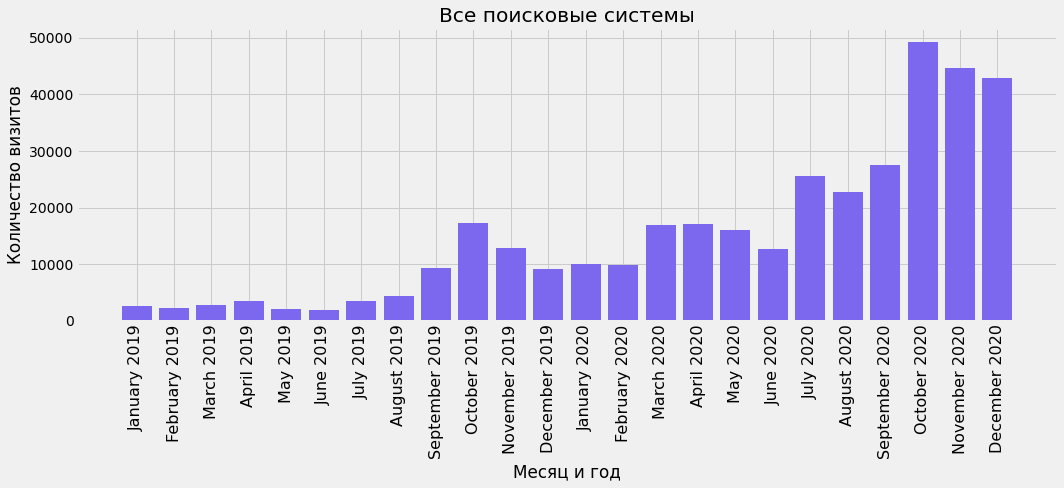

In [64]:
with plt.style.context('fivethirtyeight'):

    plt.figure(figsize=(15,7))
    
    dates_x = by_month['month_year']
    values_y = by_month['value']
    
    plt.bar(dates_x, values_y, color='mediumslateblue')
    
    plt.xticks(rotation=90, fontsize=16)
    plt.title('Все поисковые системы')
    plt.ylabel('Количество визитов')
    plt.xlabel('Месяц и год')
    plt.tight_layout()
    plt.savefig(f'traffic-from-all-search-engines-by-moths-bar-chart.png')

### Сравнение трафика из Яндекса и Google

Срез по названиям поисковых систем:

In [65]:
yandx_and_google_slice = df[(df['data_type']=='yandex') | (df['data_type']=='google')]

In [66]:
yandx_and_google_slice

,data_type,value,date,week_number_year,month_year
731,yandex,37,2019-01-01,00 2019,January 2019
732,yandex,61,2019-01-02,00 2019,January 2019
733,yandex,106,2019-01-03,00 2019,January 2019
734,yandex,98,2019-01-04,00 2019,January 2019
735,yandex,64,2019-01-05,00 2019,January 2019
...,...,...,...,...,...
2188,google,39,2020-12-27,51 2020,December 2020
2189,google,28,2020-12-28,52 2020,December 2020
2190,google,32,2020-12-29,52 2020,December 2020
2191,google,21,2020-12-30,52 2020,December 2020


Сводная таблица по полю Месяц и год (month_year) и сумме визитов из каждой поисковой системы (data_type):

In [67]:
yandx_and_google_slice_pivot = yandx_and_google_slice.pivot_table(index='month_year', columns='data_type', 
                                                                  values='value',aggfunc='sum',sort=False)

In [68]:
yandx_and_google_slice_pivot

data_type,google,yandex
month_year,,
January 2019,238,2364
February 2019,302,1913
March 2019,359,2358
April 2019,443,2939
May 2019,224,1796
June 2019,187,1654
July 2019,210,3196
August 2019,194,4151
September 2019,363,8915


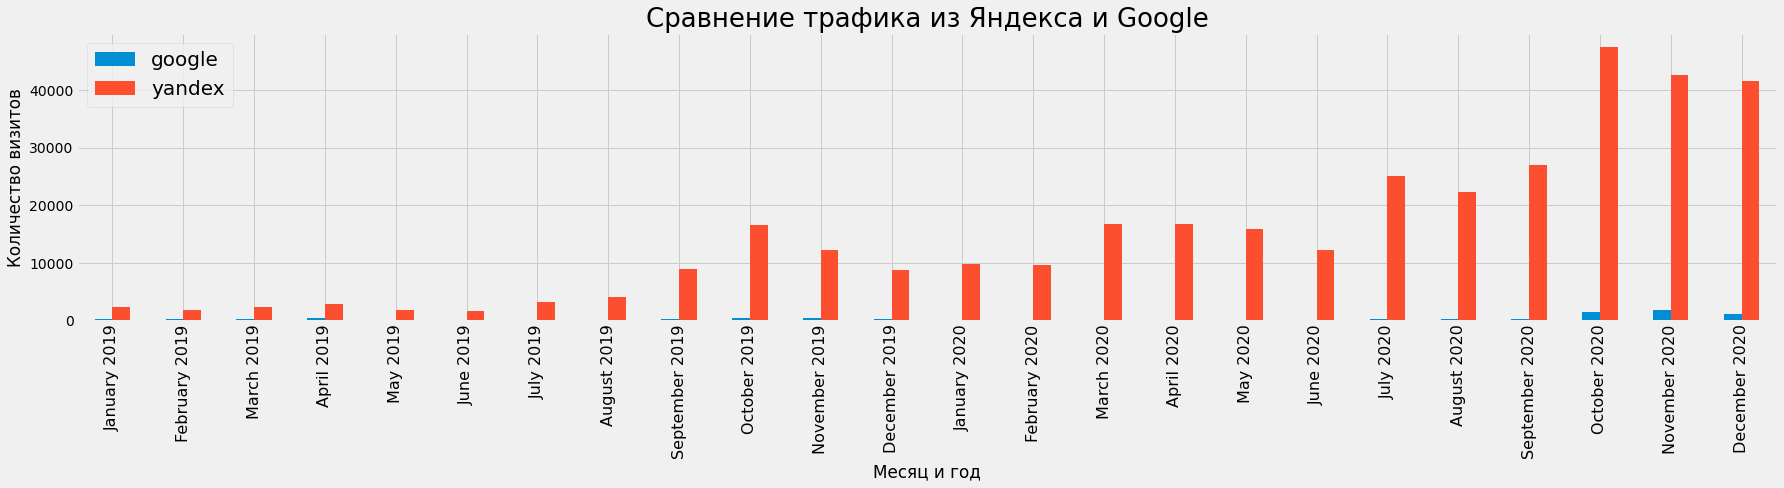

In [69]:
with plt.style.context('fivethirtyeight'):

    yandx_and_google_slice_pivot.plot(kind='bar', figsize=(25,7))
        
    plt.xticks(rotation=90, fontsize=16)
    plt.legend(prop={'size': 20})
    plt.title('Сравнение трафика из Яндекса и Google', fontsize=26)
    plt.ylabel('Количество визитов')
    plt.xlabel('Месяц и год')
    plt.tight_layout()
    plt.savefig(f'traffic-from-yandex-google-comparison.png')

### Сравнение трафика по месяцам за разные годы

Для демонстрации будет использован подготовленный ранее срез по трафику из всех поисковых систем:

In [72]:
se_all_slice.head()

,data_type,value,date,week_number_year,month_year
0,se_all,40,01-01-2019,00 2019,January 2019
1,se_all,68,02-01-2019,00 2019,January 2019
2,se_all,117,03-01-2019,00 2019,January 2019
3,se_all,105,04-01-2019,00 2019,January 2019
4,se_all,70,05-01-2019,00 2019,January 2019


Для получения нужных параметров, необходимо привести даты в формат datetime:

In [73]:
se_all_slice['date'] = pd.to_datetime(se_all_slice['date'], format='%d-%m-%Y')

/Users/andreytryastsin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


В отдельные поля нужно выделить год и название месяца:

In [74]:
se_all_slice['year'] = se_all_slice['date'].dt.year

/Users/andreytryastsin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
se_all_slice['month_name'] = se_all_slice['date'].dt.strftime('%B')

/Users/andreytryastsin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
se_all_slice_pivot = se_all_slice.pivot_table(index='month_name', columns='year', 
                                        values='value',aggfunc='sum',sort=False)

In [77]:
se_all_slice_pivot

year,2019,2020
month_name,,
January,2644,9997
February,2262,9837
March,2781,16953
April,3475,17030
May,2052,16056
June,1877,12624
July,3458,25558
August,4399,22791
September,9379,27540


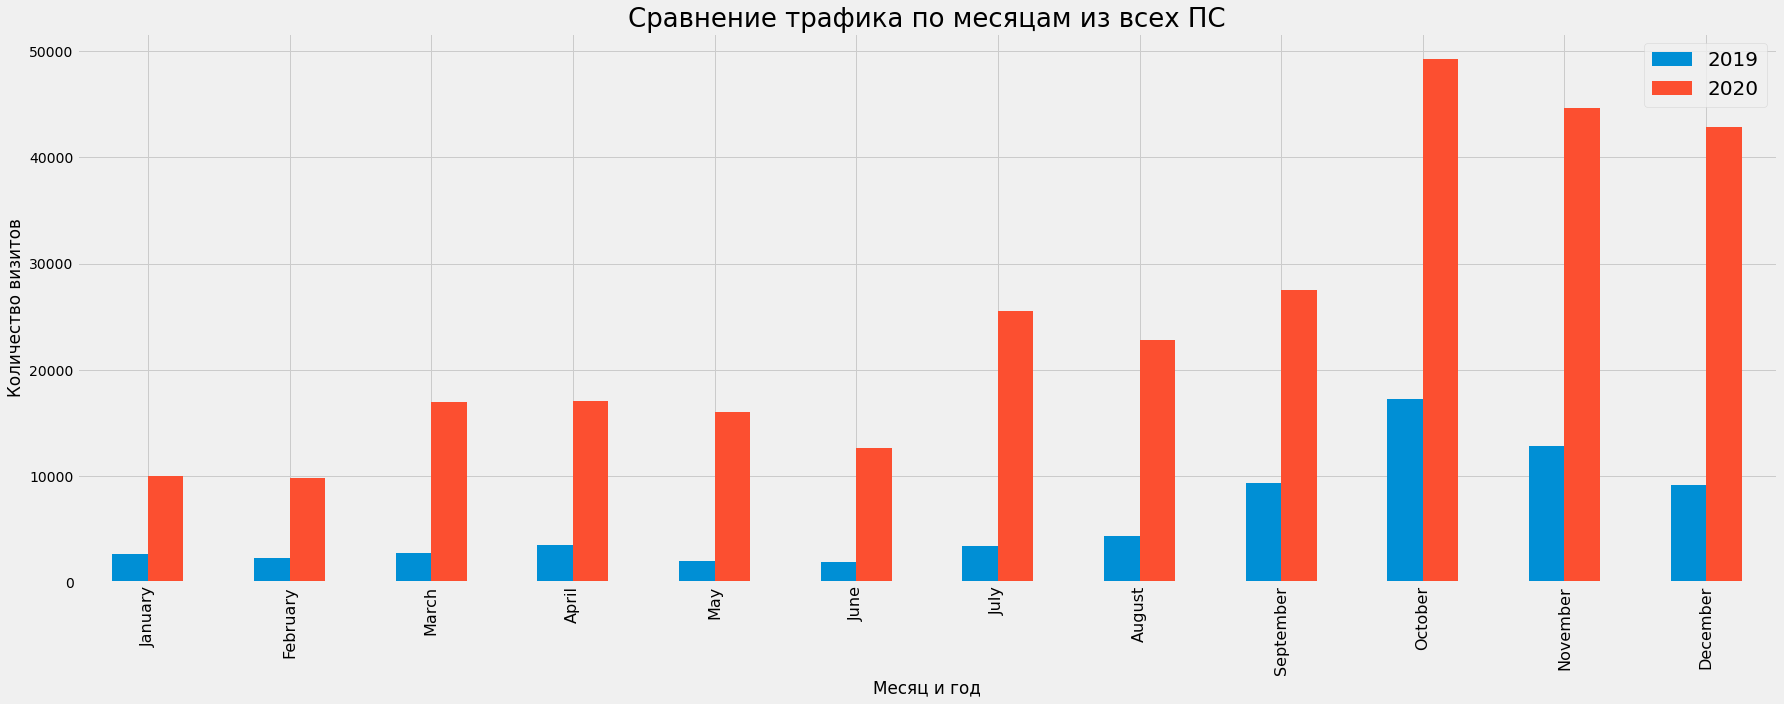

In [78]:
with plt.style.context('fivethirtyeight'):

    se_all_slice_pivot.plot(kind='bar', figsize=(25,10))
        
    plt.xticks(rotation=90, fontsize=16)
    plt.legend(prop={'size': 20})
    plt.title('Сравнение трафика по месяцам из всех ПС', fontsize=26)
    plt.ylabel('Количество визитов')
    plt.xlabel('Месяц и год')
    plt.tight_layout()
    plt.savefig(f'traffic-2019-2020-comparison.png')

# Часть 2: Получение визитов по страницам входа, анализ распределения<a class="anchor" id="9"></a>

Параметры:

In [79]:
LIMIT = 100000
DIMENSIONS = 'ym:s:startURL'
METRICS = 'ym:s:visits'
ATTRIBUTION = 'cross_device_last_significant'
FILTERS = "ym:s:LastSignTrafficSource=='organic'"

## Функция для отправки параметров

Принимает счетчик метрики, начальную и конечную дату:

In [80]:
def metrika_get_params_for_start_urls(project_yandex_metrika_counter_id, date_from, date_to):
    return {
            'id': project_yandex_metrika_counter_id,
            'date1': date_from,
            'date2': date_to,
            'attribution': ATTRIBUTION,
            'sampled': False,
            'limit': LIMIT,
            'dimensions': DIMENSIONS,
            'metrics': METRICS,
            'filters': FILTERS
    }

## Функция для получения данных из Метрики

Принимает счетчик метрики, начальную и конечную дату. Возвращает страницы входа и количество визитов зв период по каждой странице:

In [81]:
def get_search_engine_start_urls_data_from_metrika_api(project_yandex_metrika_counter_id, date_from, date_to):
    request = requests.get(METRIKA_URL_TEMPLATE,
                           headers=get_auth_headers(),
                           params=metrika_get_params_for_start_urls(project_yandex_metrika_counter_id, 
                                                                    date_from, date_to))
                
    request_data = json.loads(request.text)
    return request_data['data']

## Функция для создания таблицы

Принимает полученные из Метрики данные, преобразует их в таблицу (датафрейм):

In [82]:
def extract_urls_and_visits_quantity(data):
    pages_list = []
    visits = []
    for element in range(len(data)):
        pages_list.append(data[element]['dimensions'][0]['name'])
        visits.append(data[element]['metrics'][0])
        
    df = pd.DataFrame({'urls': pages_list,
                       'visits_quantity': visits
                      })
    df['visits_quantity'] = df['visits_quantity'].astype(int)
    
    return df

# Распределение за период<a class="anchor" id="10"></a>

В этом разделе будут получены данные за указанный период, определены типы страниц и визуализированы на круговой диаграмме.

### Функция для создания круговой диаграммы

Принимает датафрейм, название периода для подписи по оси X, и название проекта, которое будет использовано в заголовке и в имени сохраняяемого png файла:

In [83]:
def pie_plot_settings(df, period_name, project_name):
    labels = df['traffic_category'].tolist()
    
    with plt.style.context('fivethirtyeight'):
        df['visits_quantity'].plot(kind='pie',
                                   labels=labels,
                                   figsize=(25, 15),
                                   fontsize = 20,
                                   autopct='%1.1f%%',
                                   cmap=plt.get_cmap('coolwarm'))
        
        plt.ylabel('')
        plt.xlabel(period_name, fontsize = 25)
        plt.title(f'Распределение трафика из поисковых систем {project_name}', fontsize = 35)
        plt.tight_layout()
        plt.savefig(f'{project_name}-traffic-spread.png')
        plt.show() 

## Пример 1: распределение трафика da-vita.ru

In [84]:
DAVITA_COUNTER_ID = 19249012

Начальная и конечная дата:

In [85]:
date_from = '2021-04-01'

In [86]:
date_to = '2021-04-30'

### Получение данных

In [87]:
data = get_search_engine_start_urls_data_from_metrika_api(DAVITA_COUNTER_ID, date_from, date_to)

In [88]:
data

[{'dimensions': [{'name': 'https://da-vita.ru/faq/kak-nakladivat-patchi-pod-glaza.html',
    'favicon': 'da-vita.ru'}],
  'metrics': [2131.0]},
 {'dimensions': [{'name': 'https://da-vita.ru/', 'favicon': 'da-vita.ru'}],
  'metrics': [872.0]},
 {'dimensions': [{'name': 'https://da-vita.ru/beauty-blog/solncezashchitnii-krem-dlya-litsa-tela-spf-pa-kak-vybrat.html',
    'favicon': 'da-vita.ru'}],
  'metrics': [638.0]},
 {'dimensions': [{'name': 'https://da-vita.ru/beauty-blog/kak-vibrat-krem-na-leto-i-vesnu.html',
    'favicon': 'da-vita.ru'}],
  'metrics': [459.0]},
 {'dimensions': [{'name': 'https://da-vita.ru/beauty-blog/gryaz-mertvogo-morya.html',
    'favicon': 'da-vita.ru'}],
  'metrics': [348.0]},
 {'dimensions': [{'name': 'https://da-vita.ru/catalog/brendi/',
    'favicon': 'da-vita.ru'}],
  'metrics': [313.0]},
 {'dimensions': [{'name': 'https://da-vita.ru/beauty-blog/sol-mertvogo-morya---sekreti-primeneniya.html',
    'favicon': 'da-vita.ru'}],
  'metrics': [298.0]},
 {'dimension

### Преобразование полученных данных в датафрейм

In [89]:
df = extract_urls_and_visits_quantity(data)

In [90]:
df

,urls,visits_quantity
0,https://da-vita.ru/faq/kak-nakladivat-patchi-p...,2131
1,https://da-vita.ru/,872
2,https://da-vita.ru/beauty-blog/solncezashchitn...,638
3,https://da-vita.ru/beauty-blog/kak-vibrat-krem...,459
4,https://da-vita.ru/beauty-blog/gryaz-mertvogo-...,348
...,...,...
1648,https://ufa.da-vita.ru/catalog/gigi.html,1
1649,https://ufa.da-vita.ru/catalog/lavilin__hlavin...,1
1650,https://voronezh.da-vita.ru/,1
1651,https://voronezh.da-vita.ru/catalog/chernaya-i...,1


### Функция шаблон для определения типов страниц для da-vita.ru

Самый удобный и точный способ определения типов страниц - по URL. В этом случае каждый тип имеет свою вложенность или уникальные слова-маркеры в URL.

#### Пример определения типов страниц для da-vita.ru:<br>
Главная страница - main,<br>
Карточки - card - вложенность в catalog, далее 2 уровня вложенности, заканчивается на html,<br>
Статьи - blog - вложенность в beauty-blog, заканчивается на html,<br>
FAQ - faq - вложенность в faq, заканчивается на html,<br>
Отзывы - review - вложенность в otzyvy-o-kosmetike, заканчивается на html,<br>
Поддомены - subdomain - любое количество английских букв перед da-vita.ru, любое количество символов после,<br>
Категории - cat_pages, также как и карточки вложены в catalog и имеют 1 уровень вложенности после него, заканчиваются на html, если просто задать шаблон https://da-vita.ru/catalog/.*.html он будет пересекаться с карточками, поэтому в этом случае категории определяются через исключение всех карточек df[(cat) & ~(card)] - срез по "cat и НЕ card".

Функция принимает датафрейм с полученными из Метрики страницами входа и данными о количестве визитов на них за период.<br>
В переменные записываются шаблоны страниц.<br>
К датафрему применяется каждый шаблон по очереди, в новое поле traffic_category записывается название типа страниц.<br>

In [91]:
def davita(df):
    main = 'https://da-vita.ru/'
    card = df['urls'].str.contains(pat='https://da-vita.ru/catalog/.*/.*.html',regex=True)
    blog = df['urls'].str.contains(pat='https://da-vita.ru/beauty-blog/.*.html',regex=True)
    faq = df['urls'].str.contains(pat='https://da-vita.ru/faq/.*.html',regex=True)
    review = df['urls'].str.contains(pat='https://da-vita.ru/otzyvy-o-kosmetike/.*.html',regex=True)
    subdomain = df['urls'].str.contains(pat='https://.*[a-z].da-vita.ru/.*',regex=True)
    cat = df['urls'].str.contains(pat='https://da-vita.ru/catalog/.*.html',regex=True)
    cat_pages = df[(cat) & ~(card)]
    
    df['traffic_category'] = ''
    df.loc[df['urls'] == main, 'traffic_category'] = 'Главная'
    df.loc[df['urls'].isin(cat_pages['urls']), 'traffic_category'] = 'Категории'
    df.loc[df['urls'].isin(df[card]['urls']), 'traffic_category'] = 'Карточки'
    df.loc[df['urls'].isin(df[subdomain]['urls']), 'traffic_category'] = 'Региональные поддомены'
    df.loc[df['urls'].isin(df[blog]['urls']), 'traffic_category'] = 'Блог'
    df.loc[df['urls'].isin(df[faq]['urls']), 'traffic_category'] = 'FAQ'
    df.loc[df['urls'].isin(df[review]['urls']), 'traffic_category'] = 'Отзывы'
    df['traffic_category'] = df['traffic_category'].replace('', 'Другие страницы')
    
    return df

### Пример определения типов страниц

In [92]:
davita_traffic_spread = davita(df)

In [93]:
davita_traffic_spread

,urls,visits_quantity,traffic_category
0,https://da-vita.ru/faq/kak-nakladivat-patchi-p...,2131,FAQ
1,https://da-vita.ru/,872,Главная
2,https://da-vita.ru/beauty-blog/solncezashchitn...,638,Блог
3,https://da-vita.ru/beauty-blog/kak-vibrat-krem...,459,Блог
4,https://da-vita.ru/beauty-blog/gryaz-mertvogo-...,348,Блог
...,...,...,...
1648,https://ufa.da-vita.ru/catalog/gigi.html,1,Региональные поддомены
1649,https://ufa.da-vita.ru/catalog/lavilin__hlavin...,1,Региональные поддомены
1650,https://voronezh.da-vita.ru/,1,Региональные поддомены
1651,https://voronezh.da-vita.ru/catalog/chernaya-i...,1,Региональные поддомены


### Создание сводной таблицы

In [94]:
davita_traffic_spread_pivot = davita_traffic_spread.pivot_table(index='traffic_category', 
                                                                values='visits_quantity', 
                                                                aggfunc='sum').reset_index()

In [95]:
davita_traffic_spread_pivot

,traffic_category,visits_quantity
0,FAQ,3051
1,Блог,2407
2,Главная,872
3,Другие страницы,623
4,Карточки,2939
5,Категории,972
6,Отзывы,573
7,Региональные поддомены,366


### Визуализация на диаграмме

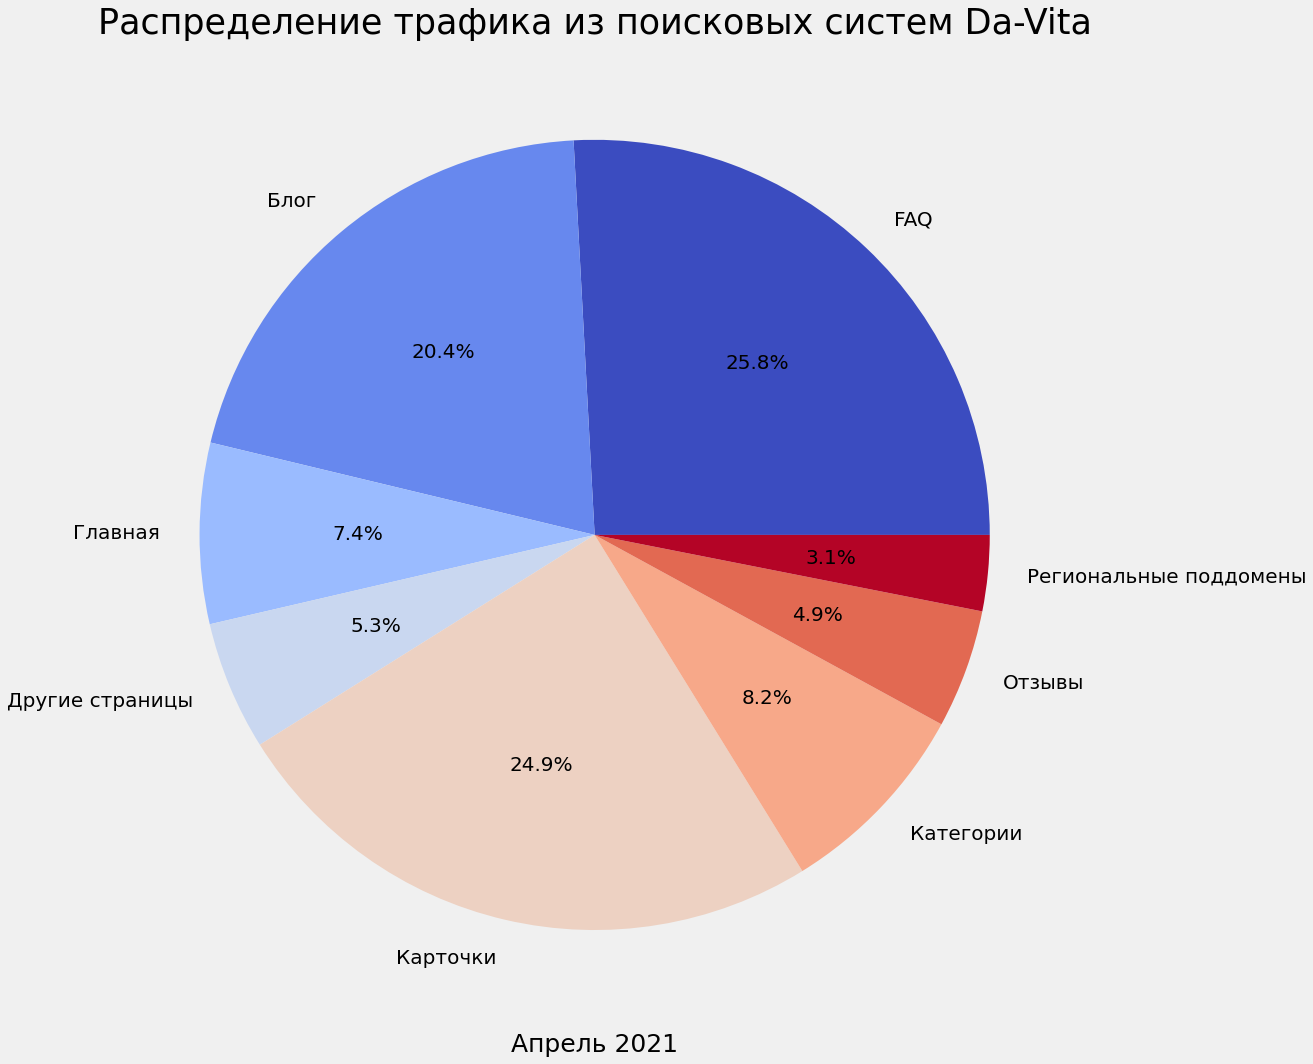

In [96]:
pie_plot_settings(davita_traffic_spread_pivot,'Апрель 2021', 'Da-Vita')

## Пример 2: распределение трафика kolesa-v-pitere.ru

Пример со вторым проектом нужен для демонстрации другого способа определения типов страниц.

In [97]:
KOLESA_COUNTER_ID = 47281992

Начальная и конечная дата:

In [98]:
date_from = '2023-04-01'

In [99]:
date_to = '2023-04-30'

### Получение данных

In [100]:
kolesa_data = get_search_engine_start_urls_data_from_metrika_api(KOLESA_COUNTER_ID, date_from, date_to)

### Преобразование данных в датафрейм

In [101]:
kolesa_df = extract_urls_and_visits_quantity(kolesa_data)

In [102]:
kolesa_df

,urls,visits_quantity
0,https://kolesa-v-pitere.ru/,930
1,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,140
2,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,140
3,https://moscow.kolesa-v-pitere.ru/,110
4,https://kolesa-v-pitere.ru/legkovye-shiny/legk...,100
...,...,...
785,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10
786,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10
787,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10
788,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10


### Функция шаблон для определения типов страниц для kolesa-v-pitere.ru

Для da-vita.ru шаблоны страниц определялись по URL. В случае с сайтом kolesa-v-pitere.ru с помощью регулярных выражений не получится определить является ли страница категорией или карточкой. Это можно было бы совершить, например если бы категория заканчивалась слэшем, а карточка была бы без слеша или заканчивалась на .html.<br>
<br>
Но на kolesa-v-pitere.ru все страницы не имеют никаких символов в конце. Можно было бы попытаться определить тип страницы по уровню вложенности, например категория всегда второй уровень https://www.kolesa-v-pitere.ru/legkovye-shiny, а карточка третий https://www.kolesa-v-pitere.ru/legkovye-shiny/zimnie_shiny_Bridgestone_Blizzak_VRX_185_60_R15_84S__11. Но на сайте на третьем и более уровне может быть другая категория https://www.kolesa-v-pitere.ru/legkovye-shiny/legkovye-shiny-po-proizvoditelyu/ и https://www.kolesa-v-pitere.ru/legkovye-shiny/legkovye-shiny-po-proizvoditelyu/bridgestone-1. <br>
<br>
Также на этом сайте создается множество страниц под уточненные запросы, поэтому такие страницы нужно определить в отдельный тип, чтобы понять сколько трафика они генерируют, но такие страниц тоже ничем не отличаются от обычных категорий.
<br>
<br>
В этом случае я использую списки алиасов карточек, категорий и созданных страниц, которые получаю из базы данных:<br>
kvp_products_aliases.csv - алиасы карточек,<br>
kvp_categories_aliases.csv - алиасы категорий,<br>
kvp_filters_aliases.csv - алиасы созданных уточненных категорий.<br>
Эти файлы находяся с папке с кодом.

#### Пример определения типов страниц для kolesa-v-pitere.ru:

Фкнкция принимает датафрейм с данными по страницам входа из Метрики. Загружаются подготовленные файлы с алиасами.<br>
<br>
Шаблон главной страницы - main,<br>
шаблон поддоменов - subdomain,<br>
<br>
В принятом датафрейме с данымми Метрики URL разделяются по слешам, получается список из элементов разделенного URL, записывается в поле splitted_url. Из списка берется последний элемент, который должен являться алиасом, записывается в поле only_alias.<br>
<br>
Далее каждый алиас сравнивается с подготовленным шаблоном main и subdomain, а также с алиасами из подготовленных файлов.<br>
<br>

In [103]:
def kvp(df):
    kvp_categories_aliases = pd.read_csv('kvp_categories_aliases.csv')
    kvp_products_aliases = pd.read_csv('kvp_products_aliases.csv')
    kvp_filters_aliases = pd.read_csv('kvp_filters_aliases.csv')
    
    main = 'https://kolesa-v-pitere.ru/'
    subdomain = df['urls'].str.contains(pat='https://.*[a-z].kolesa-v-pitere.ru/.*',regex=True)

    df['traffic_category'] = ''
    df['splitted_url'] = df['urls'].apply(lambda x: x.split('/'))
    df['only_alias'] = df['splitted_url'].apply(lambda x: x[len(x)-1])
    
    df.loc[df['urls'] == main, 'traffic_category'] = 'Главная'
    df.loc[df['only_alias'].isin(kvp_categories_aliases['alias']), 'traffic_category'] = 'Категории'
    df.loc[df['only_alias'].isin(kvp_products_aliases['alias']), 'traffic_category'] = 'Карточки'
    df.loc[df['only_alias'].isin(kvp_filters_aliases['alias']), 'traffic_category'] = 'Фильтры'
    df.loc[df['urls'].isin(df[subdomain]['urls']), 'traffic_category'] = 'Региональные поддомены'
    df['traffic_category'] = df['traffic_category'].replace('', 'Другое')
        
    return df

### Пример определения типов страниц

In [104]:
kvp_traffic_spread = kvp(kolesa_df)

In [105]:
kvp_traffic_spread

,urls,visits_quantity,traffic_category,splitted_url,only_alias
0,https://kolesa-v-pitere.ru/,930,Главная,"[https:, , kolesa-v-pitere.ru, ]",
1,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,140,Карточки,"[https:, , kolesa-v-pitere.ru, legkovye-shiny,...",letnie_shiny_Nexen_Nfera_RU5_235_55_R20_105V__3
2,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,140,Карточки,"[https:, , kolesa-v-pitere.ru, legkovye-shiny,...",letnie_shiny_Yokohama_BluEarth-Es_ES32_175_70_...
3,https://moscow.kolesa-v-pitere.ru/,110,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, ]",
4,https://kolesa-v-pitere.ru/legkovye-shiny/legk...,100,Категории,"[https:, , kolesa-v-pitere.ru, legkovye-shiny,...",sailun-atrezzo-elite
...,...,...,...,...,...
785,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",litye_kolesnye_diski_skad_KL-275_7x17_5x114_3_...
786,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",letnie-shini-nexen-nfera-sport-245-40-r19-94w-...
787,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, kolesn...",litie-kolesnie-diski-ls-204-7x16-5x114-3-et40-...
788,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, legkov...",letnie-shini-goodride-zupereco-z-107-255-60-r1...


### Создание сводной таблицы

In [106]:
kvp_traffic_spread_pivot = kvp_traffic_spread.pivot_table(index='traffic_category', 
                                                          values='visits_quantity', 
                                                          aggfunc='sum').reset_index()

In [107]:
kvp_traffic_spread_pivot

,traffic_category,visits_quantity
0,Главная,930
1,Другое,610
2,Карточки,4700
3,Категории,1840
4,Региональные поддомены,2180
5,Фильтры,1070


### Визуализация

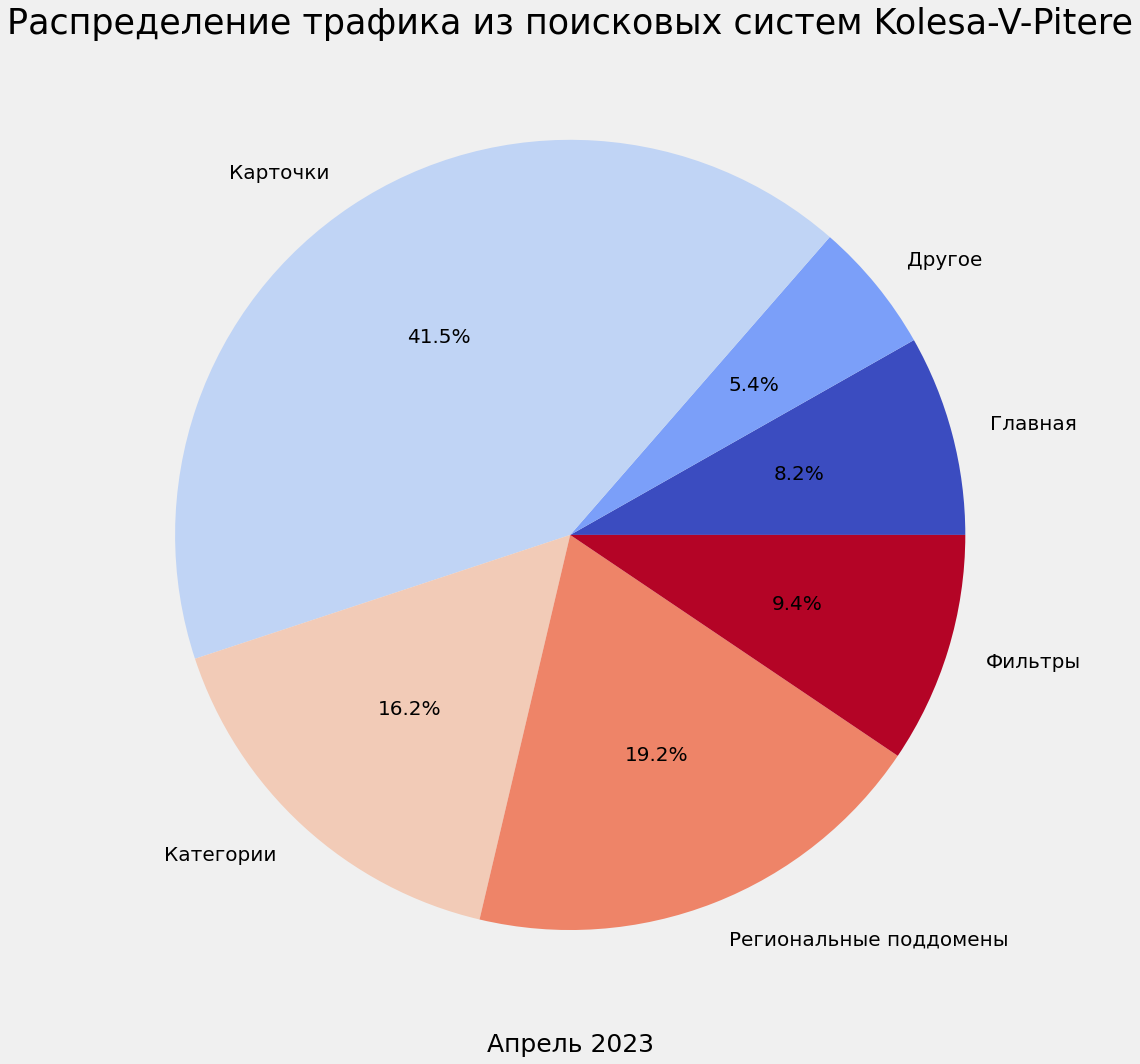

In [108]:
pie_plot_settings(kvp_traffic_spread_pivot, 'Апрель 2023', 'Kolesa-V-Pitere')

# Распределение по месяцам<a class="anchor" id="11"></a>

В этом разделе также будут получены данные и определены типы страниц, но не за концретный период, а за каждый месяц в рамках какого-то периода, например за несколько лет. Данные будут визуализированы на столбчатой диаграмме с накоплением.

## Функция для получения списка первых чисел месяца в рамках диапазона

Принимает начальную и конечную дату:

In [109]:
def create_list_of_fist_dates_of_months(date_from, date_to):
    list_of_fist_dates_of_months = []
    for month in pd.period_range(start=date_from,end=date_to, freq='M'):
        list_of_fist_dates_of_months.append(str(month)+'-01')
    return list_of_fist_dates_of_months

### Пример списка

In [110]:
create_list_of_fist_dates_of_months('2020-01-01', '2021-02-01')

['2020-01-01',
 '2020-02-01',
 '2020-03-01',
 '2020-04-01',
 '2020-05-01',
 '2020-06-01',
 '2020-07-01',
 '2020-08-01',
 '2020-09-01',
 '2020-10-01',
 '2020-11-01',
 '2020-12-01',
 '2021-01-01',
 '2021-02-01']

## Функция для получения последнего числа месяца

Функция принимает первый день месяца и возвращает последний день месяца.

In [111]:
def get_last_day_of_month(first_day_of_month):
    timestamp_date = pd.Timestamp(first_day_of_month)
    return (timestamp_date + MonthEnd(0)).strftime('%Y-%m-%d')

## Функция для получения данных за каждый месяц

Принимает номер счетчика, начальную и конечные даты.<br>
Берет каждое первое число каждого месяца из диапазона, <br>
получает последнее число месяца,<br> 
получается данные по страницам входа за месяц,<br>
преобразует данные из Метрики в датафрейм,<br>
добавляет в датафрейм поле с названием месяца,<br>
которое получается из первого числа месяца,<br>
превращает датафрейм в список словарей,<br>
добавляет в общий список,<br>
возвращает датафрейм с данными за все месяцы за указанный период:

In [112]:
def get_search_engine_start_urls_by_months(counter_id, date_from, date_to):
    
    list_of_dicts = []
    for first_day_of_month in create_list_of_fist_dates_of_months(date_from, date_to):
        last_day_of_month = get_last_day_of_month(first_day_of_month)

        data = get_search_engine_start_urls_data_from_metrika_api(counter_id, 
                                                                  first_day_of_month, 
                                                                  last_day_of_month)


        df = extract_urls_and_visits_quantity(data)
        df['month_name'] = pd.Timestamp(first_day_of_month).strftime('%B %Y')

        list_of_dicts += df.to_dict('records')
    
    return pd.DataFrame.from_dict(list_of_dicts)

## Функция для создания столбчатой диаграммы с накоплением

Принимает датафрейм, название периода для вывода на ось Х, название проекта для вывода в заголовок:

In [113]:
def bar_plot_settings(df, period_name, project_name):
    with plt.style.context('fivethirtyeight'):
        df.set_index('traffic_category').reindex(df.set_index('traffic_category').sum().index, axis=1)\
        .T.plot(kind='bar', stacked=True, figsize=(25,15), cmap=plt.get_cmap('coolwarm'))
        plt.xlabel(period_name, fontsize = 25)
        plt.ylabel('Количество визитов', fontsize = 25)
        plt.title(f'Распределение трафика из поисковых систем {project_name}',fontsize = 35)
        plt.legend(loc=0, prop={'size': 20})
        plt.xticks(rotation=90, fontsize=18)
        plt.tight_layout()
        plt.savefig(f'{project_name}-traffic-spread-period.png')
        plt.show()

## Пример 1: распределение трафика da-vita.ru

In [114]:
DAVITA_COUNTER_ID = 19249012

Начальная и конечная дата:

In [115]:
date_from = '2017-01-01'

In [116]:
date_to = '2023-04-30'

### Получение данных

In [117]:
davita_traffic_data_df = get_search_engine_start_urls_by_months(DAVITA_COUNTER_ID, date_from, date_to)

In [118]:
davita_traffic_data_df

,urls,visits_quantity,month_name
0,http://da-vita.ru/,1540,January 2017
1,http://da-vita.ru/shops/,402,January 2017
2,http://da-vita.ru/catalog/,261,January 2017
3,http://da-vita.ru/brends/,82,January 2017
4,http://da-vita.ru/shops/firmennii_magazin_kosm...,56,January 2017
...,...,...,...
120083,https://voronezh.da-vita.ru/catalog/bb-cc-tona...,1,April 2023
120084,https://voronezh.da-vita.ru/catalog/holy-land....,1,April 2023
120085,https://voronezh.da-vita.ru/catalog/klapp.html,1,April 2023
120086,https://voronezh.da-vita.ru/catalog/shampuni-c...,1,April 2023


### Определение типов страниц

Ранее был подготовлен шаблон для определение типов страниц:

In [119]:
davita_traffic_spread_period = davita(davita_traffic_data_df)

In [120]:
davita_traffic_spread_period

,urls,visits_quantity,month_name,traffic_category
0,http://da-vita.ru/,1540,January 2017,Другие страницы
1,http://da-vita.ru/shops/,402,January 2017,Другие страницы
2,http://da-vita.ru/catalog/,261,January 2017,Другие страницы
3,http://da-vita.ru/brends/,82,January 2017,Другие страницы
4,http://da-vita.ru/shops/firmennii_magazin_kosm...,56,January 2017,Другие страницы
...,...,...,...,...
120083,https://voronezh.da-vita.ru/catalog/bb-cc-tona...,1,April 2023,Региональные поддомены
120084,https://voronezh.da-vita.ru/catalog/holy-land....,1,April 2023,Региональные поддомены
120085,https://voronezh.da-vita.ru/catalog/klapp.html,1,April 2023,Региональные поддомены
120086,https://voronezh.da-vita.ru/catalog/shampuni-c...,1,April 2023,Региональные поддомены


### Создание сводной таблицы

In [121]:
davita_traffic_spread_period_pivot = (davita_traffic_spread_period.groupby(['traffic_category','month_name'], 
                                                                          sort=False)['visits_quantity']
                                                                            .sum().unstack()).reset_index()


In [122]:
davita_traffic_spread_period_pivot

month_name,traffic_category,January 2017,February 2017,March 2017,April 2017,May 2017,June 2017,July 2017,August 2017,September 2017,...,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,Другие страницы,4466.0,4575.0,5894.0,5698.0,5607.0,4926.0,4113.0,4869.0,1473.0,...,413.0,422.0,366.0,410.0,528.0,717.0,766.0,686.0,890.0,738.0
1,Главная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,915.0,...,758.0,934.0,785.0,955.0,1089.0,1136.0,992.0,913.0,999.0,759.0
2,Категории,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1331.0,...,1030.0,1229.0,1093.0,1304.0,1470.0,1823.0,1888.0,1890.0,2270.0,2033.0
3,Карточки,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,634.0,...,2908.0,3461.0,3354.0,3929.0,3546.0,3980.0,5484.0,4718.0,5411.0,5656.0
4,Блог,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,1042.0,855.0,786.0,948.0,1073.0,1110.0,1452.0,1312.0,2366.0,2632.0
5,FAQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,777.0,747.0,772.0,1022.0,1224.0,1531.0,3256.0,3024.0,4568.0,4504.0
6,Региональные поддомены,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,262.0,290.0,215.0,188.0,180.0,237.0,250.0,222.0,268.0,303.0
7,Отзывы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,349.0,417.0,440.0,637.0,715.0,649.0,763.0,760.0,950.0,908.0


### Визуализация

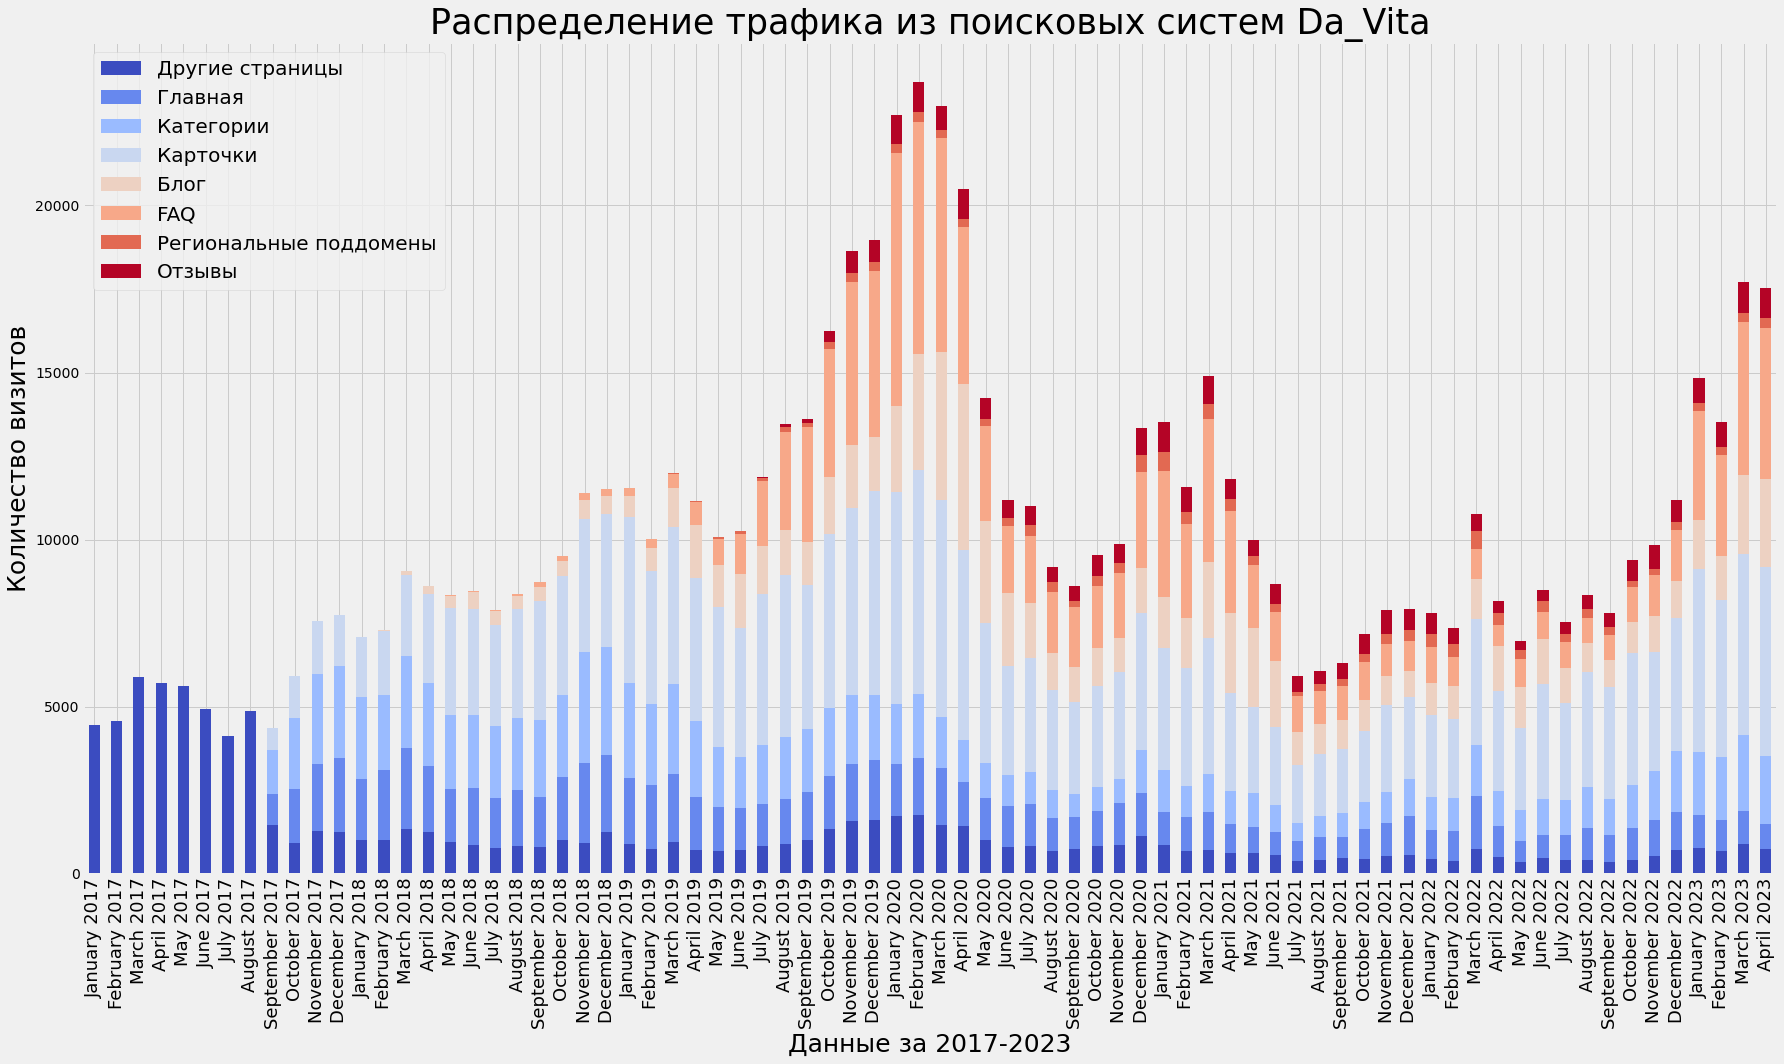

In [123]:
bar_plot_settings(davita_traffic_spread_period_pivot, 'Данные за 2017-2023', 'Da_Vita')

## Пример 2: распределение трафика kolesa-v-pitere.ru

Пример со вторым проектом нужен для демонстрации другого способа определения типов страниц.

In [124]:
KOLESA_COUNTER_ID = 47281992

Начальная и конечная дата:

In [125]:
date_from = '2020-04-01'

In [126]:
date_to = '2023-04-30'

### Получение данных

In [127]:
kolesa_traffic_data_df = get_search_engine_start_urls_by_months(KOLESA_COUNTER_ID, date_from, date_to)

In [128]:
kolesa_traffic_data_df

,urls,visits_quantity,month_name
0,http://kolesa-v-pitere.ru/,19,April 2020
1,http://kolesa-v-pitere.ru/catalog/bmw-x6-koles...,9,April 2020
2,http://kolesa-v-pitere.ru/catalog/mercedes-s-c...,8,April 2020
3,http://kolesa-v-pitere.ru/catalog/bmw-x6-koles...,7,April 2020
4,http://kolesa-v-pitere.ru/catalog/bmw-x6-koles...,6,April 2020
...,...,...,...
31300,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10,April 2023
31301,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10,April 2023
31302,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10,April 2023
31303,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10,April 2023


### Определение типов страниц

Ранее был подготовлен шаблон для определение типов страниц:

In [129]:
kolesa_traffic_spread_period = kvp(kolesa_traffic_data_df)

In [130]:
kolesa_traffic_spread_period

,urls,visits_quantity,month_name,traffic_category,splitted_url,only_alias
0,http://kolesa-v-pitere.ru/,19,April 2020,Другое,"[http:, , kolesa-v-pitere.ru, ]",
1,http://kolesa-v-pitere.ru/catalog/bmw-x6-koles...,9,April 2020,Другое,"[http:, , kolesa-v-pitere.ru, catalog, bmw-x6-...",
2,http://kolesa-v-pitere.ru/catalog/mercedes-s-c...,8,April 2020,Другое,"[http:, , kolesa-v-pitere.ru, catalog, mercede...",
3,http://kolesa-v-pitere.ru/catalog/bmw-x6-koles...,7,April 2020,Другое,"[http:, , kolesa-v-pitere.ru, catalog, bmw-x6-...",
4,http://kolesa-v-pitere.ru/catalog/bmw-x6-koles...,6,April 2020,Другое,"[http:, , kolesa-v-pitere.ru, catalog, bmw-x6-...",
...,...,...,...,...,...,...
31300,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",litye_kolesnye_diski_skad_KL-275_7x17_5x114_3_...
31301,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",letnie-shini-nexen-nfera-sport-245-40-r19-94w-...
31302,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, kolesn...",litie-kolesnie-diski-ls-204-7x16-5x114-3-et40-...
31303,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, legkov...",letnie-shini-goodride-zupereco-z-107-255-60-r1...


### Создание сводной таблицы

In [131]:
kolesa_traffic_spread_period_pivot = (kolesa_traffic_spread_period.groupby(['traffic_category','month_name'],
                                                                           sort=False)['visits_quantity']
                                                                              .sum().unstack()).reset_index()


In [132]:
kolesa_traffic_spread_period_pivot

month_name,traffic_category,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020,...,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,Другое,217.0,145.0,141.0,163.0,169.0,250.0,301.0,313.0,237.0,...,442.0,270.0,327.0,250.0,313.0,153.0,215.0,312.0,751.0,610.0
1,Главная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,323.0,220.0,343.0,330.0,430.0,220.0,243.0,343.0,630.0,930.0
2,Карточки,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1062.0,1150.0,1005.0,1270.0,1793.0,909.0,1200.0,1498.0,6302.0,4700.0
3,Категории,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,264.0,310.0,300.0,390.0,529.0,313.0,637.0,758.0,1495.0,1840.0
4,Фильтры,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.0,50.0,253.0,370.0,396.0,179.0,322.0,348.0,608.0,1070.0
5,Региональные поддомены,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,558.0,470.0,477.0,550.0,1081.0,857.0,821.0,600.0,1121.0,2180.0


### Визуализация

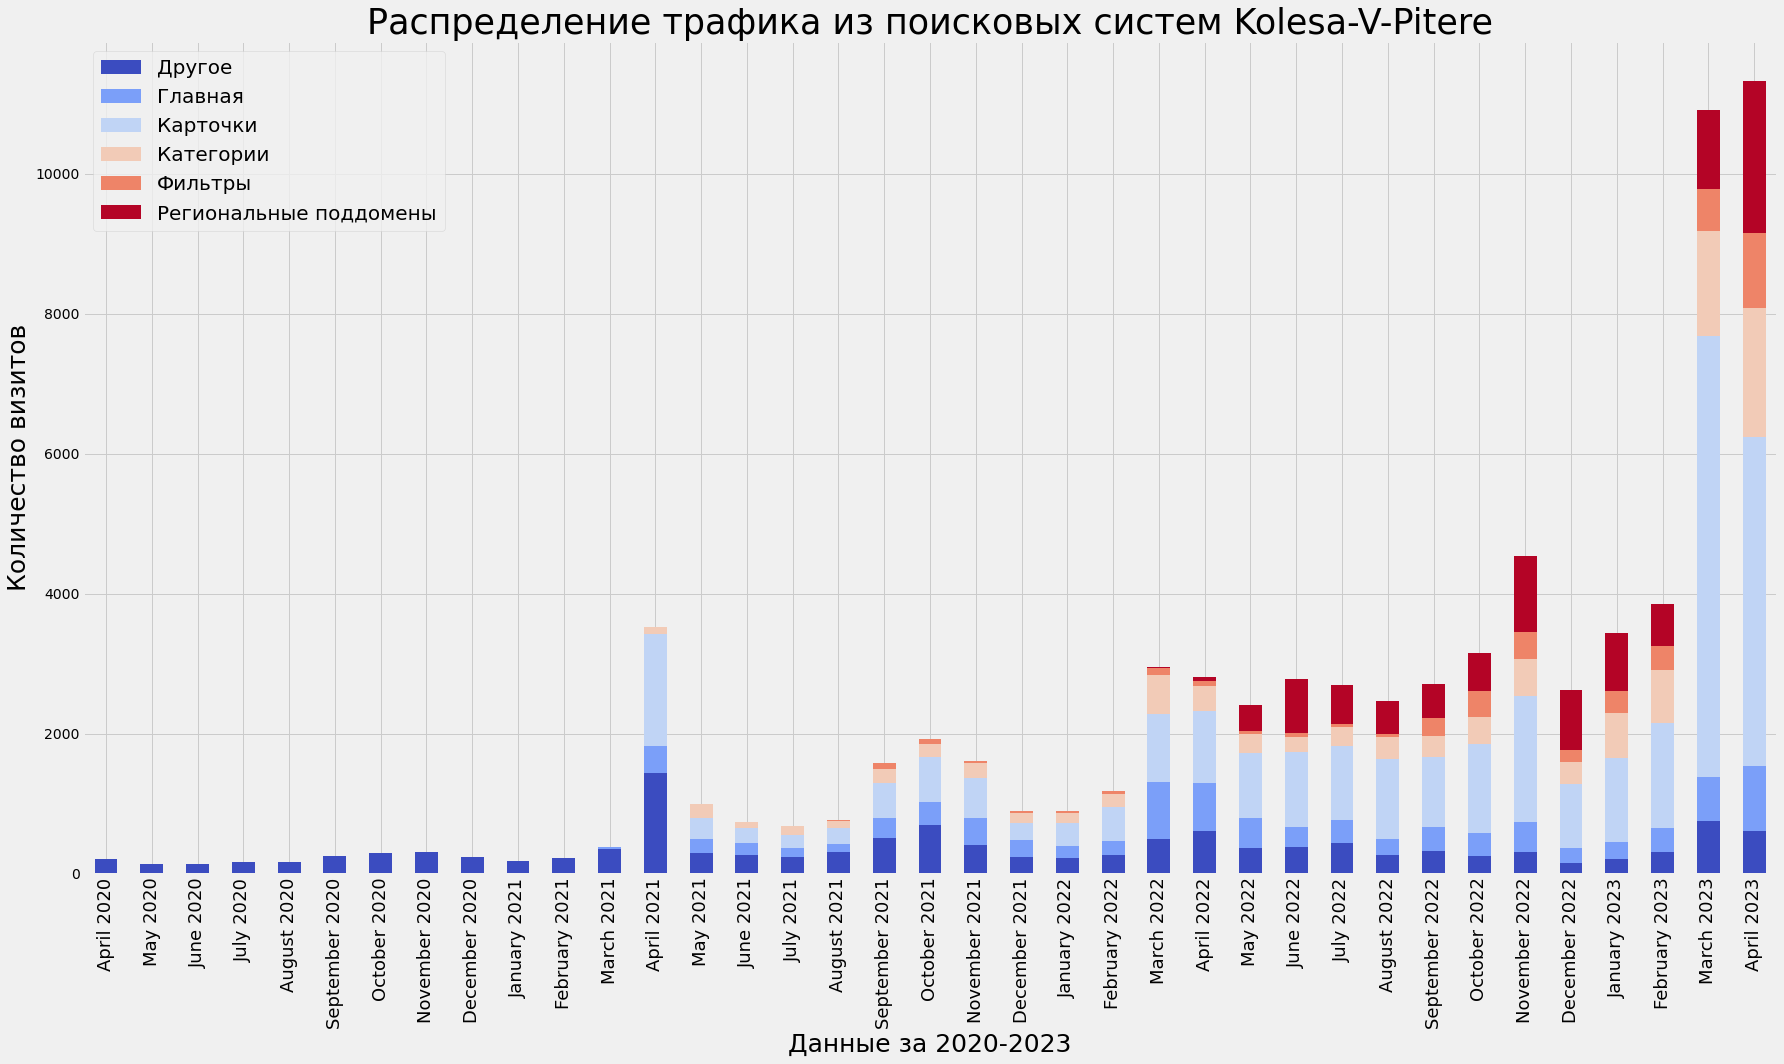

In [133]:
bar_plot_settings(kolesa_traffic_spread_period_pivot, 'Данные за 2020-2023', 'Kolesa-V-Pitere')

# Часть 3: Получение визитов по страницам входа, анализ динамики трафика по каждому URL<a class="anchor" id="12"></a>

В этой части будут те же функции, которые использовались для получения данных по страницам входа и анализа распределения трафика.

## Пример 1: динамика трафика по URL da-vita.ru

In [134]:
DAVITA_COUNTER_ID = 19249012

Начальная и конечная дата:

In [135]:
date_from = '2021-01-01'

In [136]:
date_to = '2023-04-30'

### Получение данных

In [137]:
davita_traffic_data_df = get_search_engine_start_urls_by_months(DAVITA_COUNTER_ID, date_from, date_to)

In [138]:
davita_traffic_data_df

,urls,visits_quantity,month_name
0,https://da-vita.ru/faq/kak-nakladivat-patchi-p...,2270,January 2021
1,https://da-vita.ru/,980,January 2021
2,https://da-vita.ru/beauty-blog/gryaz-mertvogo-...,410,January 2021
3,https://da-vita.ru/catalog/brendi/,410,January 2021
4,https://da-vita.ru/beauty-blog/sol-mertvogo-mo...,300,January 2021
...,...,...,...
48930,https://voronezh.da-vita.ru/catalog/bb-cc-tona...,1,April 2023
48931,https://voronezh.da-vita.ru/catalog/holy-land....,1,April 2023
48932,https://voronezh.da-vita.ru/catalog/klapp.html,1,April 2023
48933,https://voronezh.da-vita.ru/catalog/shampuni-c...,1,April 2023


### Определение типов страниц

Ранее был подготовлен шаблон для определение типов страниц:

In [139]:
davita_traffic_spread_period = davita(davita_traffic_data_df)

In [140]:
davita_traffic_spread_period

,urls,visits_quantity,month_name,traffic_category
0,https://da-vita.ru/faq/kak-nakladivat-patchi-p...,2270,January 2021,FAQ
1,https://da-vita.ru/,980,January 2021,Главная
2,https://da-vita.ru/beauty-blog/gryaz-mertvogo-...,410,January 2021,Блог
3,https://da-vita.ru/catalog/brendi/,410,January 2021,Другие страницы
4,https://da-vita.ru/beauty-blog/sol-mertvogo-mo...,300,January 2021,Блог
...,...,...,...,...
48930,https://voronezh.da-vita.ru/catalog/bb-cc-tona...,1,April 2023,Региональные поддомены
48931,https://voronezh.da-vita.ru/catalog/holy-land....,1,April 2023,Региональные поддомены
48932,https://voronezh.da-vita.ru/catalog/klapp.html,1,April 2023,Региональные поддомены
48933,https://voronezh.da-vita.ru/catalog/shampuni-c...,1,April 2023,Региональные поддомены


### Создание сводной таблицы

Для такого анализа датафрейм слишком большой, нужно делать срез по какому-нибудь типу страниц.

Для примера сделаю срез по блогу:

In [141]:
davita_blog_traffic = davita_traffic_spread_period[davita_traffic_spread_period['traffic_category'] == 'Блог']

In [142]:
davita_blog_traffic

,urls,visits_quantity,month_name,traffic_category
2,https://da-vita.ru/beauty-blog/gryaz-mertvogo-...,410,January 2021,Блог
4,https://da-vita.ru/beauty-blog/sol-mertvogo-mo...,300,January 2021,Блог
5,https://da-vita.ru/beauty-blog/antioksidanti-v...,210,January 2021,Блог
6,https://da-vita.ru/beauty-blog/solncezashchitn...,200,January 2021,Блог
11,https://da-vita.ru/beauty-blog/avokado-v-kosme...,130,January 2021,Блог
...,...,...,...,...
47864,https://da-vita.ru/beauty-blog/kak-vibrat-milo...,1,April 2023,Блог
47865,https://da-vita.ru/beauty-blog/kak-vibrat-milo...,1,April 2023,Блог
47866,https://da-vita.ru/beauty-blog/kakie-masla-pod...,1,April 2023,Блог
47867,https://da-vita.ru/beauty-blog/sol-mertvogo-mo...,1,April 2023,Блог


In [143]:
davita_blog_traffic_pivot = (davita_blog_traffic.groupby(['urls','month_name'],
                                                         sort=False)['visits_quantity']
                                                        .sum().unstack()).reset_index()


In [144]:
davita_blog_traffic_pivot

month_name,urls,January 2021,February 2021,March 2021,April 2021,May 2021,June 2021,July 2021,August 2021,September 2021,...,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,https://da-vita.ru/beauty-blog/gryaz-mertvogo-...,410.0,276.0,368.0,348.0,311.0,347.0,241.0,269.0,263.0,...,259.0,251.0,204.0,192.0,239.0,207.0,279.0,280.0,324.0,341.0
1,https://da-vita.ru/beauty-blog/sol-mertvogo-mo...,300.0,227.0,288.0,298.0,416.0,269.0,195.0,185.0,248.0,...,165.0,139.0,138.0,221.0,178.0,187.0,229.0,163.0,238.0,198.0
2,https://da-vita.ru/beauty-blog/antioksidanti-v...,210.0,168.0,172.0,234.0,176.0,152.0,44.0,58.0,36.0,...,9.0,5.0,10.0,9.0,15.0,11.0,8.0,11.0,8.0,9.0
3,https://da-vita.ru/beauty-blog/solncezashchitn...,200.0,217.0,459.0,638.0,773.0,727.0,322.0,162.0,89.0,...,297.0,148.0,70.0,58.0,46.0,61.0,116.0,89.0,252.0,389.0
4,https://da-vita.ru/beauty-blog/avokado-v-kosme...,130.0,81.0,63.0,74.0,64.0,46.0,30.0,34.0,46.0,...,59.0,25.0,35.0,38.0,36.0,42.0,34.0,25.0,41.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,https://da-vita.ru/beauty-blog/solncezashchitn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
103,https://da-vita.ru/beauty-blog/izrail-skaya-ko...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
104,https://da-vita.ru/beauty-blog/avokado-v-kosme...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
105,https://da-vita.ru/beauty-blog/izrail-skaya-ko...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [145]:
davita_blog_traffic_pivot.fillna(0, inplace=True)

Все числовые данные стали float, для красоты всем колонкам начиная с January 2021 задам тип int:

In [146]:
(davita_blog_traffic_pivot
 [davita_blog_traffic_pivot.loc[:, 'January 2021':].columns]) = (davita_blog_traffic_pivot
                                                                 [davita_blog_traffic_pivot.loc[:, 'January 2021':]
                                                                  .columns].astype(int))


In [147]:
davita_blog_traffic_pivot

month_name,urls,January 2021,February 2021,March 2021,April 2021,May 2021,June 2021,July 2021,August 2021,September 2021,...,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,https://da-vita.ru/beauty-blog/gryaz-mertvogo-...,410,276,368,348,311,347,241,269,263,...,259,251,204,192,239,207,279,280,324,341
1,https://da-vita.ru/beauty-blog/sol-mertvogo-mo...,300,227,288,298,416,269,195,185,248,...,165,139,138,221,178,187,229,163,238,198
2,https://da-vita.ru/beauty-blog/antioksidanti-v...,210,168,172,234,176,152,44,58,36,...,9,5,10,9,15,11,8,11,8,9
3,https://da-vita.ru/beauty-blog/solncezashchitn...,200,217,459,638,773,727,322,162,89,...,297,148,70,58,46,61,116,89,252,389
4,https://da-vita.ru/beauty-blog/avokado-v-kosme...,130,81,63,74,64,46,30,34,46,...,59,25,35,38,36,42,34,25,41,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,https://da-vita.ru/beauty-blog/solncezashchitn...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
103,https://da-vita.ru/beauty-blog/izrail-skaya-ko...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
104,https://da-vita.ru/beauty-blog/avokado-v-kosme...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
105,https://da-vita.ru/beauty-blog/izrail-skaya-ko...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Визуализация

In [148]:
davita_blog_heatmap = davita_blog_traffic_pivot.style.background_gradient(axis=0)  

In [149]:
davita_blog_heatmap

month_name,urls,January 2021,February 2021,March 2021,April 2021,May 2021,June 2021,July 2021,August 2021,September 2021,October 2021,November 2021,December 2021,January 2022,February 2022,March 2022,April 2022,May 2022,June 2022,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,https://da-vita.ru/beauty-blog/gryaz-mertvogo-morya.html,410,276,368,348,311,347,241,269,263,250,269,237,304,287,251,271,310,261,259,251,204,192,239,207,279,280,324,341
1,https://da-vita.ru/beauty-blog/sol-mertvogo-morya---sekreti-primeneniya.html,300,227,288,298,416,269,195,185,248,279,245,226,280,203,159,175,110,190,165,139,138,221,178,187,229,163,238,198
2,https://da-vita.ru/beauty-blog/antioksidanti-v-kosmetike.html,210,168,172,234,176,152,44,58,36,57,48,26,36,17,11,14,20,15,9,5,10,9,15,11,8,11,8,9
3,https://da-vita.ru/beauty-blog/solncezashchitnii-krem-dlya-litsa-tela-spf-pa-kak-vybrat.html,200,217,459,638,773,727,322,162,89,78,62,86,87,160,223,395,390,503,297,148,70,58,46,61,116,89,252,389
4,https://da-vita.ru/beauty-blog/avokado-v-kosmetike-svoistva-dlya-chego-ispol-zuetsya.html,130,81,63,74,64,46,30,34,46,74,63,51,76,65,55,54,40,53,59,25,35,38,36,42,34,25,41,37
5,https://da-vita.ru/beauty-blog/collagen-v-kosmetike-svoistva.html,80,53,74,43,39,34,16,25,16,18,13,11,5,8,10,7,10,3,5,4,5,6,7,6,6,2,9,7
6,https://da-vita.ru/beauty-blog/kak-izbavitsya-ot-kuperoza-na-litse.html,80,150,172,161,92,71,35,40,29,34,41,41,40,40,36,43,40,44,23,17,14,29,39,21,31,33,33,34
7,https://da-vita.ru/beauty-blog/kak-vibrat-kosmetiku-pri-psoriaze.html,60,51,57,44,61,50,19,16,20,28,50,60,47,34,48,37,20,32,27,30,31,30,40,47,97,63,133,147
8,https://da-vita.ru/beauty-blog/kak-izbavitsya-ot-prishei-ugrei-na-litse.html,40,59,69,51,46,27,12,21,12,8,8,10,10,8,10,11,0,10,9,15,10,12,9,11,5,8,15,18
9,https://da-vita.ru/beauty-blog/gialuronovaya-kislota-v-sostave-kosmetiki-zachem-ona-nujna.html,10,12,12,12,13,9,14,3,9,7,2,4,3,4,8,4,10,7,4,2,4,1,0,2,1,0,1,3


###  Экспорт для анализа в Excel

In [150]:
writer_kernel = pd.ExcelWriter('Da-Vita Blog URL Heatmap.xlsx', engine='xlsxwriter')
davita_blog_heatmap.to_excel(writer_kernel, index=False)
writer_kernel.save()

## Пример 2: динамика трафика по URL kolesa-v-pitere.ru

Пример со вторым проектом нужен для демонстрации другого способа определения типов страниц.

In [151]:
KOLESA_COUNTER_ID = 47281992

Начальная и конечная дата:

In [152]:
date_from = '2021-04-01'

In [153]:
date_to = '2023-04-30'

### Получение данных

In [154]:
kolesa_traffic_data_df = get_search_engine_start_urls_by_months(KOLESA_COUNTER_ID, date_from, date_to)

In [155]:
kolesa_traffic_data_df

,urls,visits_quantity,month_name
0,https://kolesa-v-pitere.ru/,400,April 2021
1,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,110,April 2021
2,https://kolesa-v-pitere.ru/kolesnye-diski/lity...,40,April 2021
3,https://kolesa-v-pitere.ru/kolesnye-diski/lity...,30,April 2021
4,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,30,April 2021
...,...,...,...
29537,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10,April 2023
29538,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10,April 2023
29539,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10,April 2023
29540,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10,April 2023


### Определение типов страниц

Ранее был подготовлен шаблон для определение типов страниц:

In [156]:
kolesa_traffic_spread_period = kvp(kolesa_traffic_data_df)

In [157]:
kolesa_traffic_spread_period

,urls,visits_quantity,month_name,traffic_category,splitted_url,only_alias
0,https://kolesa-v-pitere.ru/,400,April 2021,Главная,"[https:, , kolesa-v-pitere.ru, ]",
1,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,110,April 2021,Карточки,"[https:, , kolesa-v-pitere.ru, legkovye-shiny,...",letnie_shiny_ZETA_Impero_245_50_R18_100Y_XL_Ru...
2,https://kolesa-v-pitere.ru/kolesnye-diski/lity...,40,April 2021,Другое,"[https:, , kolesa-v-pitere.ru, kolesnye-diski,...",litye_kolesnye_diski_skad_pantera_5_5x14_4x100...
3,https://kolesa-v-pitere.ru/kolesnye-diski/lity...,30,April 2021,Другое,"[https:, , kolesa-v-pitere.ru, kolesnye-diski,...",litye_kolesnye_diski_Tech_Line_650_6_5x16_5x11...
4,https://kolesa-v-pitere.ru/legkovye-shiny/letn...,30,April 2021,Карточки,"[https:, , kolesa-v-pitere.ru, legkovye-shiny,...",letnie_shiny_Yokohama_BluEarth-Es_ES32_175_70_...
...,...,...,...,...,...,...
29537,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",litye_kolesnye_diski_skad_KL-275_7x17_5x114_3_...
29538,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",letnie-shini-nexen-nfera-sport-245-40-r19-94w-...
29539,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, kolesn...",litie-kolesnie-diski-ls-204-7x16-5x114-3-et40-...
29540,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, legkov...",letnie-shini-goodride-zupereco-z-107-255-60-r1...


### Создание сводной таблицы

Для примера сделаю срез по региональным поддоменам:

In [158]:
kolesa_subdomains_traffic = (kolesa_traffic_spread_period[kolesa_traffic_spread_period['traffic_category'] 
                                                          == 'Региональные поддомены'])

In [159]:
kolesa_subdomains_traffic

,urls,visits_quantity,month_name,traffic_category,splitted_url,only_alias
4546,https://moscow.kolesa-v-pitere.ru/legkovye-shiny,10,March 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, legkovye...",legkovye-shiny
4552,https://moscow.kolesa-v-pitere.ru/,18,April 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, ]",
4554,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,14,April 2022,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",letnie-shini-aosen-hh301-185-65-r15-88h-t674357
4581,https://moscow.kolesa-v-pitere.ru/letnie_shiny...,5,April 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, letnie_s...",letnie_shiny_Goodyear_Eagle_Sport_TZ_235_55_R1...
4610,https://moscow.kolesa-v-pitere.ru/legkovye-shiny,4,April 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, legkovye...",legkovye-shiny
...,...,...,...,...,...,...
29537,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",litye_kolesnye_diski_skad_KL-275_7x17_5x114_3_...
29538,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",letnie-shini-nexen-nfera-sport-245-40-r19-94w-...
29539,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, kolesn...",litie-kolesnie-diski-ls-204-7x16-5x114-3-et40-...
29540,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, legkov...",letnie-shini-goodride-zupereco-z-107-255-60-r1...


Из оставшихся URL нужно оставить домен:

In [160]:
kolesa_subdomains_traffic['domain'] = kolesa_subdomains_traffic['urls'].apply(lambda x: x.split('/'))

/Users/andreytryastsin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [161]:
kolesa_subdomains_traffic['domain'] = kolesa_subdomains_traffic['domain'].apply(lambda x: x[2])

/Users/andreytryastsin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [162]:
kolesa_subdomains_traffic

,urls,visits_quantity,month_name,traffic_category,splitted_url,only_alias,domain
4546,https://moscow.kolesa-v-pitere.ru/legkovye-shiny,10,March 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, legkovye...",legkovye-shiny,moscow.kolesa-v-pitere.ru
4552,https://moscow.kolesa-v-pitere.ru/,18,April 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, ]",,moscow.kolesa-v-pitere.ru
4554,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,14,April 2022,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",letnie-shini-aosen-hh301-185-65-r15-88h-t674357,rostov-na-donu.kolesa-v-pitere.ru
4581,https://moscow.kolesa-v-pitere.ru/letnie_shiny...,5,April 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, letnie_s...",letnie_shiny_Goodyear_Eagle_Sport_TZ_235_55_R1...,moscow.kolesa-v-pitere.ru
4610,https://moscow.kolesa-v-pitere.ru/legkovye-shiny,4,April 2022,Региональные поддомены,"[https:, , moscow.kolesa-v-pitere.ru, legkovye...",legkovye-shiny,moscow.kolesa-v-pitere.ru
...,...,...,...,...,...,...,...
29537,https://rostov-na-donu.kolesa-v-pitere.ru/kole...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",litye_kolesnye_diski_skad_KL-275_7x17_5x114_3_...,rostov-na-donu.kolesa-v-pitere.ru
29538,https://rostov-na-donu.kolesa-v-pitere.ru/legk...,10,April 2023,Региональные поддомены,"[https:, , rostov-na-donu.kolesa-v-pitere.ru, ...",letnie-shini-nexen-nfera-sport-245-40-r19-94w-...,rostov-na-donu.kolesa-v-pitere.ru
29539,https://voronezh.kolesa-v-pitere.ru/kolesnye-d...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, kolesn...",litie-kolesnie-diski-ls-204-7x16-5x114-3-et40-...,voronezh.kolesa-v-pitere.ru
29540,https://voronezh.kolesa-v-pitere.ru/legkovye-s...,10,April 2023,Региональные поддомены,"[https:, , voronezh.kolesa-v-pitere.ru, legkov...",letnie-shini-goodride-zupereco-z-107-255-60-r1...,voronezh.kolesa-v-pitere.ru


In [163]:
kolesa_subdomains_traffic_pivot = (kolesa_subdomains_traffic.groupby(['domain','month_name'],
                                                                     sort=False)['visits_quantity']
                                   .sum().unstack()).reset_index()


In [164]:
kolesa_subdomains_traffic_pivot

month_name,domain,March 2022,April 2022,May 2022,June 2022,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,moscow.kolesa-v-pitere.ru,10.0,40.0,313.0,653.0,484.0,462.0,369.0,530.0,1047.0,836.0,798.0,503.0,980.0,2070.0
1,rostov-na-donu.kolesa-v-pitere.ru,NaN,21.0,56.0,125.0,74.0,73.0,73.0,20.0,18.0,13.0,11.0,24.0,35.0,20.0
2,yandexwebcache.net,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kazan.kolesa-v-pitere.ru,NaN,NaN,NaN,NaN,NaN,2.0,18.0,NaN,6.0,NaN,2.0,11.0,14.0,10.0
4,krasnodar.kolesa-v-pitere.ru,NaN,NaN,NaN,NaN,NaN,3.0,17.0,NaN,8.0,4.0,5.0,19.0,22.0,50.0
5,voronezh.kolesa-v-pitere.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,2.0,20.0,21.0,30.0
6,ekaterinburg.kolesa-v-pitere.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,19.0,17.0,NaN
7,samara.kolesa-v-pitere.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,9.0,NaN
8,kolesa-v-pitere.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
9,saratov.kolesa-v-pitere.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,22.0,NaN


In [165]:
kolesa_subdomains_traffic_pivot.fillna(0, inplace=True)

Все числовые данные стали float, для красоты всем колонкам начиная с March 2022 задам тип int:

In [166]:
(kolesa_subdomains_traffic_pivot
 [kolesa_subdomains_traffic_pivot.loc[:, 'March 2022':].columns]) = (kolesa_subdomains_traffic_pivot
                                                                       [kolesa_subdomains_traffic_pivot.loc[:, 'March 2022':]
                                                                        .columns].astype(int))


In [167]:
kolesa_subdomains_traffic_pivot

month_name,domain,March 2022,April 2022,May 2022,June 2022,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,moscow.kolesa-v-pitere.ru,10,40,313,653,484,462,369,530,1047,836,798,503,980,2070
1,rostov-na-donu.kolesa-v-pitere.ru,0,21,56,125,74,73,73,20,18,13,11,24,35,20
2,yandexwebcache.net,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,kazan.kolesa-v-pitere.ru,0,0,0,0,0,2,18,0,6,0,2,11,14,10
4,krasnodar.kolesa-v-pitere.ru,0,0,0,0,0,3,17,0,8,4,5,19,22,50
5,voronezh.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,2,4,2,20,21,30
6,ekaterinburg.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,2,19,17,0
7,samara.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,1,2,9,0
8,kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,saratov.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,0,1,22,0


### Визуализация

In [168]:
kolesa_blog_heatmap = kolesa_subdomains_traffic_pivot.style.background_gradient(axis=0)  

In [169]:
kolesa_blog_heatmap

month_name,domain,March 2022,April 2022,May 2022,June 2022,July 2022,August 2022,September 2022,October 2022,November 2022,December 2022,January 2023,February 2023,March 2023,April 2023
0,moscow.kolesa-v-pitere.ru,10,40,313,653,484,462,369,530,1047,836,798,503,980,2070
1,rostov-na-donu.kolesa-v-pitere.ru,0,21,56,125,74,73,73,20,18,13,11,24,35,20
2,yandexwebcache.net,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,kazan.kolesa-v-pitere.ru,0,0,0,0,0,2,18,0,6,0,2,11,14,10
4,krasnodar.kolesa-v-pitere.ru,0,0,0,0,0,3,17,0,8,4,5,19,22,50
5,voronezh.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,2,4,2,20,21,30
6,ekaterinburg.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,2,19,17,0
7,samara.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,1,2,9,0
8,kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,saratov.kolesa-v-pitere.ru,0,0,0,0,0,0,0,0,0,0,0,1,22,0


###  Экспорт для анализа в Excel

In [170]:
writer_kernel = pd.ExcelWriter('Kolesa-V-Pitere Subdomains URL Heatmap.xlsx', engine='xlsxwriter')
kolesa_blog_heatmap.to_excel(writer_kernel, index=False)
writer_kernel.save()